In [1]:
import sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import numpy as np
from copy import deepcopy
from IPython.display import clear_output
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch

from modelagnostic_superior_training.inducingPointSampler import *
from modelagnostic_superior_training.globalModel import *
from modelagnostic_superior_training.SABER import *
from modelagnostic_superior_training.AL_base import *
from modelagnostic_superior_training.AL_framework import activeLearner

%matplotlib inline

saveDir = 'results'
dataDir = 'data'

inputDim = 2
inputSpaceBounds = np.array([[0]*inputDim,[1]*inputDim])

testUniformly = False

repetitions = 1
iteration = 0
if iteration == 0:
    dataFileName = 'ThermalCavity_2D_Ra_1e7_nx_064'
    bins = 64 # poolSize = 8606 (= 63*4*16 + 61*4*4 + 60*60*1)
    dataName = 'tC_1st'
if iteration == 1:
    dataFileName = 'ThermalCavity_2D_Ra_1e7_nx_065_mean_2ndIter'
    bins = 65
    dataName = 'tC_2nd'
if iteration == 2:
    dataFileName = 'ThermalCavity_2D_Ra_1e7_nx_053_mean_3rdIter'
    bins = 53
    dataName = 'tC_3rd'
if iteration == 3:
    dataFileName = 'ThermalCavity_2D_Ra_1e7_nx_098_mean_4thIter'
    bins = 98
    dataName = 'tC_4th'
    
resultFile = os.path.join(saveDir, dataName + '_resultFile.tar')
dataFile = os.path.join(dataDir, dataFileName + '.npz')

heatDataset = np.load(dataFile, allow_pickle = True)
xPool = heatDataset['X']
yPool = heatDataset['y']
xPlot = xPool
yPlot = yPool
if 'importanceWeights' in heatDataset.files:
    densityPlot = 1/heatDataset['importanceWeights'].ravel()
else:
    densityPlot = heatDataset['inputDensity'].ravel()
densityPlot /= np.sum(densityPlot)/densityPlot.size
poolDensity = densityPlot

voxelInxesXplot = np.floor(xPlot * bins).astype(int)
voxelwiseDensity = np.empty([bins, bins])
for inx,vInx in enumerate(voxelInxesXplot):
    voxelwiseDensity[vInx[0],vInx[1]] = densityPlot[inx]
def poolDensityFunction(x, inputSpaceBounds):
    # find the respective voxel of x
    voxelInx = np.floor(x * bins).astype(int)
    # return voxel density of x
    density = np.empty(len(x))
    for inx,vInx in enumerate(voxelInx):
        density[inx] = voxelwiseDensity[vInx[0],vInx[1]]
    return density
# testDensity = poolDensity

def randInputUnifFromDataset(size, inputSpaceBounds, inputsOnly = True):
    inx = myPoolSampling(size, 1., pPoolofPool)
    X = xPool[inx]
    if inputsOnly:
        return X
    Y = yPool[inx]
    return X, inx, Y

localNoiseVariance = None

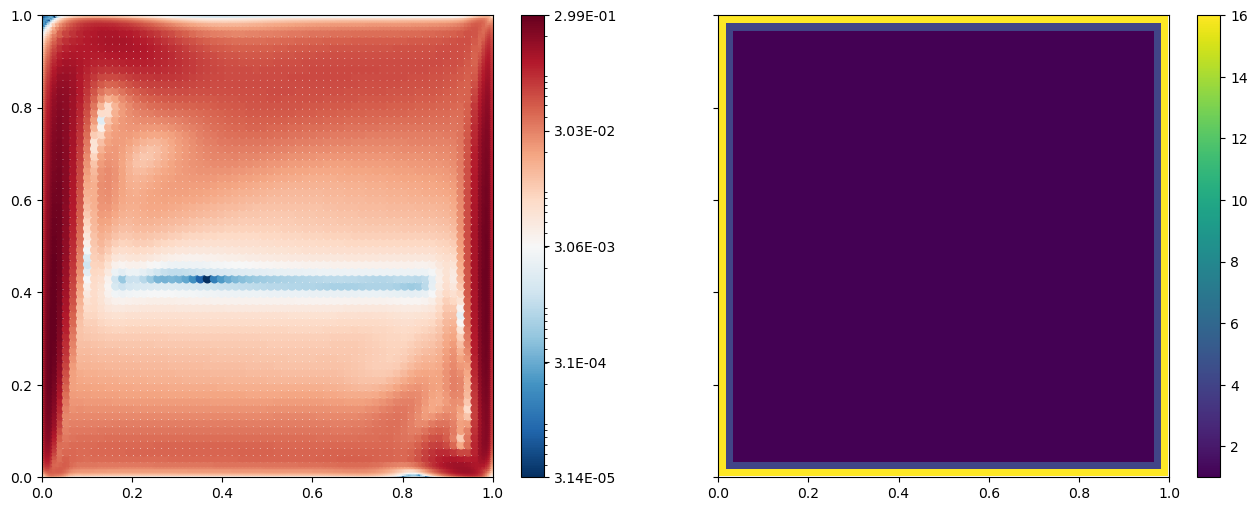

In [2]:
fig, axes = plt.subplots(1, 2, sharex = True,sharey=True)
fig.set_figheight(6)
fig.set_figwidth(16)
plt0 = axes[0].scatter(xPlot[:,0], xPlot[:,1], c=yPlot.flat, norm=colors.LogNorm(vmin=min(yPlot), vmax=max(yPlot)), s=4/densityPlot, cmap="RdBu_r")
ticks = np.logspace(np.log10(min(yPlot)), np.log10(max(yPlot)), 5)
cbar0 = plt.colorbar(plt0,ax=axes[0], ticks=ticks.ravel())
null = cbar0.ax.set_yticklabels([myScientificFormat(a) for a in ticks.flat])

h = axes[1].hist2d(xPlot[:,0], xPlot[:,1], bins = bins)
plt.colorbar(h[3],ax=axes[1])

if np.ndim(axes) == 0:
    axes.set_xlim((0,1))
    axes.set_ylim((0,1))
elif np.ndim(axes) == 1:
    for bb in axes:
        bb.set_xlim((0,1))
        bb.set_ylim((0,1))
else:
    for aa in axes:
        for bb in aa:
            bb.set_xlim((0,1))
            bb.set_ylim((0,1))
plt.draw()
plt.pause(2)
plt.close(fig)

In [3]:
################ reasonable parameter groups #################

# experimental parameters
def initExpPars():
    expPars = {}
    expPars['validationSize'] = None
    expPars['testSize'] = None
    expPars['valLoss'] = 'mll'
    expPars['trainingSizes'] = []
    expPars['iters'] = 0
    expPars['repetitions'] = 1
    expPars['splitRatio'] = 1
    expPars['labelModel'] = True
    expPars['derivativeModel'] = False
    return expPars
expPars = initExpPars()
expPars['trainingSizes'] = [6000]
expPars['iters'] = len(expPars['trainingSizes'])
expPars['validationSize'] = len(xPool) - expPars['trainingSizes'][0]
expPars['testSize'] = len(xPool) - expPars['trainingSizes'][0] - expPars['validationSize']
expPars['valLoss'] = 'mse'

# AL-related parameters
def initALPars():
    alPars = {}
    alPars['initialSamplingStrategy'] = 'random'
    alPars['Q'] = np.Inf
    alPars['inputDim'] = None
    alPars['inputSpaceBounds'] = None
    alPars['intrinsicDim'] = None
    alPars['updateTrainingDensity'] = True
    alPars['samplingAlgorithm'] = 'Random' # how to sample from proposed superior training density after update
    alPars['noiseFree'] = False
    alPars['homoscedastic'] = True
    alPars['correctLFCforNoise'] = True
    return alPars
    
alPars = initALPars()
alPars['Q'] = 1
alPars['inputDim'] = inputDim
alPars['inputSpaceBounds'] = inputSpaceBounds
alPars['correctLFCforNoise'] = False
alPars['noiseFree'] = True
alPars['initialSamplingStrategy'] = 'pool'

def initIPselectionPars():
    ipSelectionPars = {}
    # inducing point initialization strategy
    ipSelectionPars['ipComplexityExponent'] = 0.
    ipSelectionPars['IPstrategyExpert'] = 'SVGD' # 'SVGD', 'Random', 'KMeans', 'GFF'
    ipSelectionPars['IPstrategyGate'] = 'SVGD' # NOTE: Cannot be 'GFF' due to missing labels
    # SVGD related parameters
    ipSelectionPars['svgdIters'] = 200
    ipSelectionPars['svgdRepulsionPropToDensity'] = True
    ipSelectionPars['svgdVersion'] = 'v2'
    ipSelectionPars['svgdIPrefSize'] = None
    ipSelectionPars['svgdSigma'] = 1e0
    ipSelectionPars['svgdInitStepSize'] = 1e-1
    ipSelectionPars['svgdFinalStepSize'] = 1e-3

    ipSelectionPars['KMeansInit'] = 'k-means++' # 'random', 'k-means++'
    ipSelectionPars['KMeansMaxIter'] = 300
    ipSelectionPars['KMeansDistributional'] = True
    
    ipSelectionPars['GFFthreshold'] = 1e-2
    return ipSelectionPars

ipSelectionPars = initIPselectionPars()
ipSelectionPars['ipComplexityExponent'] = 0.5

ipSelectionPars['IPstrategyExpert'] = 'SVGD'
ipSelectionPars['IPstrategyGate'] = 'SVGD'
ipSelectionPars['svgdInitStepSize'] = 1e-2
ipSelectionPars['svgdFinalStepSize'] = 1e-4
ipSelectionPars['svgdSigma'] = 1.2e-2
ipSelectionPars['svgdIPrefSize'] = 500

def initModelPars():
    modelPars = {}
    
    # general model design and training
    modelPars['maxSizeAnalytic'] = None
    modelPars['num_workers'] = None
    modelPars['max_processes'] = None
    modelPars['minEPOCH'] = 0
    modelPars['maxEPOCH'] = np.Inf
    
    modelPars['plotFrequencyFactor'] = 5
    modelPars['patienceFactor'] = 1
    modelPars['validationFrequency'] = 1
    modelPars['subValidationFrequency'] = 1
    
    modelPars['LR_pre'] = 1e-1
    modelPars['LR'] = 1e-2
    modelPars['minLR'] = 1e-3
    
    modelPars['lrFactorGate'] = 1e0
    modelPars['lrFactorGPRmean'] = 1e0
    modelPars['lrFactorGPRhyperparameters'] = 2e-1
    modelPars['lrFactorIPlocations'] = 1e-2 # I have no good experience with adapting inducing point positions at all
    
    modelPars['weightDecay'] = 0.
    modelPars['jitter'] = 0.
    modelPars['cholJitter'] = 1e-16
    modelPars['doublePrecision'] = False
    
    modelPars['kernel'] = 'gaussian'
    modelPars['applyARD'] = False
    modelPars['has_global_noise'] = True
    modelPars['has_task_noise'] = False
    
    # global model hyperpars
    modelPars['globalModel'] = 'exactGP'
    modelPars['preTrainEpochsGlobal'] = 1
    modelPars['smallARDbandwidthPenalty'] = 0.
    
    modelPars['numIPsGlobal'] = None
    modelPars['batchSizeGlobal'] = None
    
    modelPars['initMeanGlobal'] = None
    modelPars['initSigmaGlobal'] = 1e0
    modelPars['initLambdaGlobal'] = 1e0
    modelPars['initNoiseLevelGlobal'] = 1e0
    modelPars['initARDscales'] = None
    
    modelPars['fixedNoiseGlobal'] = False
    modelPars['fixedMeanGlobal'] = False
    modelPars['fixedLambdaGlobal'] = False
    modelPars['fixedSigmaGlobal'] = False
    modelPars['fixedIPlocationsGlobal'] = True
    modelPars['inducingCovarTypeGlobal'] = 'scalar' # 'scalar', 'diag' or 'full'
    
    # expert model hyperpars
    modelPars['expertModel'] = 'exactGP'
    modelPars['preTrainEpochsExpert'] = int(2**6)
    
    modelPars['numIPsExpert'] = None
    modelPars['batchSizeExpert'] = None
    
    modelPars['initMeanExpert'] = None
    modelPars['initLambdaExpert'] = 1e0
    modelPars['initNoiseLevelExpert'] = 1e0
    
    modelPars['fixedNoiseExpert'] = False
    modelPars['fixedMeanExpert'] = False
    modelPars['fixedLambdaExpert'] = True
    modelPars['fixedIPlocationsExpert'] = True
    modelPars['inducingCovarTypeExpert'] = 'scalar' # 'scalar', 'diag' or 'full'
    
    # gate model hyperpars
    modelPars['numIPsGate'] = None
    modelPars['batchSizeGate'] = None
    
    modelPars['initSigmaGate'] = 1e0
    modelPars['initLambdaGate'] = 1e0
    
    modelPars['fixedSigmaGate'] = True
    modelPars['fixedLambdaGate'] = True
    modelPars['fixedIPlocationsGate'] = True
    modelPars['gateOutputType'] = 'independent' #'independent', 'dependent'
    modelPars['inducingCovarTypeGate'] = 'scalar' # 'scalar', 'diag' or 'full'
    
    # MoE model hyperpars
    modelPars['fixedExperts'] = False
    modelPars['expertBandwidths'] = []
    modelPars['smallBandwidthPenalty'] = 0.
    modelPars['expertHardSparsity'] = len(modelPars['expertBandwidths']) # the final maximal number of experts the gate chooses; note that we loose continuity of the regressor, iff chosen too small
    modelPars['sparsifyAfterValiationIterations'] = 2
    modelPars['initSparsificationAfterValiationIterations'] = 5
    modelPars['noisy_gating'] = True
    modelPars['noisy_gating_decaying'] = 0.5 #0.
    modelPars['noisy_gating_b'] = False
    modelPars['noisy_gating_w'] = False
    modelPars['gate_noise_stdDev'] = 1e-1
    
    return modelPars

modelPars = initModelPars()

# general model design and training
modelPars['maxEPOCH'] = 1000
modelPars['subValidationFrequency'] = 2
modelPars['lrPre'] = 1e-1
modelPars['lr'] = 1e-1
modelPars['min_lr'] = 1e-3

modelPars['lrFactorGate'] = 1e-1
modelPars['lrFactorGPRmean'] = 1e0
modelPars['lrFactorGPRhyperparameters'] = 2e-1
modelPars['lrFactorIPlocations'] = 0. # I have no good experience with adapting inducing point positions at all

modelPars['jitter'] = 1e-11 #0.
modelPars['cholJitter'] = 1e-11
modelPars['doublePrecision'] = True

modelPars['validationFrequency'] = 4
modelPars['subValidationFrequency'] = 2

# global model hyperpars
modelPars['initSigmaGlobal'] = 1e-2
modelPars['initLambdaGlobal'] = 1e1
modelPars['numIPsGlobal'] = 1000
modelPars['batchSizeGlobal'] = 250
modelPars['fixedNoiseGlobal'] = True
modelPars['fixedMeanGlobal'] = True
modelPars['fixedLambdaGlobal'] = True
modelPars['fixedSigmaGlobal'] = True

# expert model hyperpars
modelPars['numIPsExpert'] = 1000
modelPars['batchSizeExpert'] = 250
modelPars['initNoiseLevelExpert'] = 1e-9
modelPars['initLambdaExpert'] = 1e1
modelPars['preTrainEpochsExpert'] = int(2**4)

# gate model hyperpars
modelPars['numIPsGate'] = 400
modelPars['batchSizeGate'] = 250
modelPars['initSigmaGate'] = 5e-2
modelPars['initLambdaGate'] = 1e2

# MoE model hyperpars
modelPars['fixedExperts'] = True
modelPars['smallBandwidthPenalty'] = 5e-7
modelPars['expertBandwidths'] = 4 * 10**(np.linspace(-5/2+1/3,-5/2+1/3+8/4,9))
modelPars['expertHardSparsity'] = 6 # the final maximal number of experts the gate chooses; Heuristic: 4 = 2d

In [6]:
def printSquareCavity(saberModel):
    
    gateTrainState = saberModel.model.gate.training
    expertTrainState = saberModel.model.experts.training
    expertLikelihoodState = saberModel.model.likelihood.training
    
    saberModel.model.gate.eval()
    if not saberModel.pars['fixedExperts']:
        saberModel.model.experts.eval()
        saberModel.model.likelihood.eval()
        
    #sigmaPlot = saberModel.localBandwidthFunction(xPlot)
    with torch.no_grad():
        prediction, expert_output_distributions, gateValues, inxes, sigmaPlot = saberModel(torch.from_numpy(xPlot).type(saberModel.yExpert.dtype), returnSigmaPredictions = True, combine = False, predictionsOnly = True)
    sigmaPlot = sigmaPlot.detach().numpy()
    
    if hasattr(saberModel.model.experts[0].model.covar_module.base_kernel, 'raw_lengthscale'):
        sigRange = [saberModel.model.experts[0].model.covar_module.base_kernel.lengthscale, saberModel.model.experts[-1].model.covar_module.base_kernel.lengthscale]
    else:
        sigRange = [saberModel.model.experts[0].model.covar_module.base_kernel.base_kernel.lengthscale, saberModel.model.experts[-1].model.covar_module.base_kernel.base_kernel.lengthscale]
        
    if gateTrainState:
        saberModel.model.gate.train()
    if expertTrainState:
        saberModel.model.experts.train()
    if expertLikelihoodState:
        saberModel.model.likelihood.train()
    
    fig, axes = plt.subplots(1, 2, sharex = True,sharey=True)
    fig.set_figheight(6)
    fig.set_figwidth(16)
    plt0 = axes[0].scatter(xPlot[:,0], xPlot[:,1], c=yPlot.flat, norm=colors.LogNorm(vmin=min(yPlot), vmax=max(yPlot)), s=4/densityPlot, cmap="RdBu_r")
    ticks = np.logspace(np.log10(min(yPlot)), np.log10(max(yPlot)), 5)
    cbar0 = plt.colorbar(plt0,ax=axes[0], ticks=ticks.ravel())
    null = cbar0.ax.set_yticklabels([myScientificFormat(a) for a in ticks.flat])
    
    z1_plot = axes[1].scatter(xPlot[:,0], xPlot[:,1], c=sigmaPlot, s=4/densityPlot, cmap="jet", norm=colors.LogNorm(vmin=sigRange[0], vmax=sigRange[1]))
    plt.colorbar(z1_plot,ax=axes[1])
    
    if np.ndim(axes) == 0:
        axes.set_xlim((0,1))
        axes.set_ylim((0,1))
    elif np.ndim(axes) == 1:
        for bb in axes:
            bb.set_xlim((0,1))
            bb.set_ylim((0,1))
    else:
        for aa in axes:
            for bb in aa:
                bb.set_xlim((0,1))
                bb.set_ylim((0,1))
    plt.draw()
    plt.pause(2)
    plt.close(fig)
    
    expertUsage = [vals.sum().item()/len(xPlot) for vals in gateValues]
    print('individual expert usage:', [myScientificFormat(u,2) for u in expertUsage])

find inducing points
apply SVGD sigma 8.49E-03
initialize exact GP with 1000 IPs at bandwidth 1E-02 and lambda 1E+01
load model from stateDict
median global RMSE
[nan]
median global MAE
[nan]
median global max AE
[nan]
initialize new experts
apply SVGD sigma 8.49E-03
expert 0
initialize exact GP with 1000 IPs at bandwidth 2.73E-02 and lambda 1E+01
No pre-train needed for exact GP
expert 1
initialize exact GP with 1000 IPs at bandwidth 4.85E-02 and lambda 1E+01
No pre-train needed for exact GP
expert 2
initialize exact GP with 1000 IPs at bandwidth 8.62E-02 and lambda 1E+01
No pre-train needed for exact GP
expert 3
initialize exact GP with 1000 IPs at bandwidth 1.53E-01 and lambda 1E+01
No pre-train needed for exact GP
expert 4
initialize exact GP with 1000 IPs at bandwidth 2.73E-01 and lambda 1E+01
No pre-train needed for exact GP
expert 5
initialize exact GP with 1000 IPs at bandwidth 4.85E-01 and lambda 1E+01
No pre-train needed for exact GP
expert 6
initialize exact GP with 1000 IPs

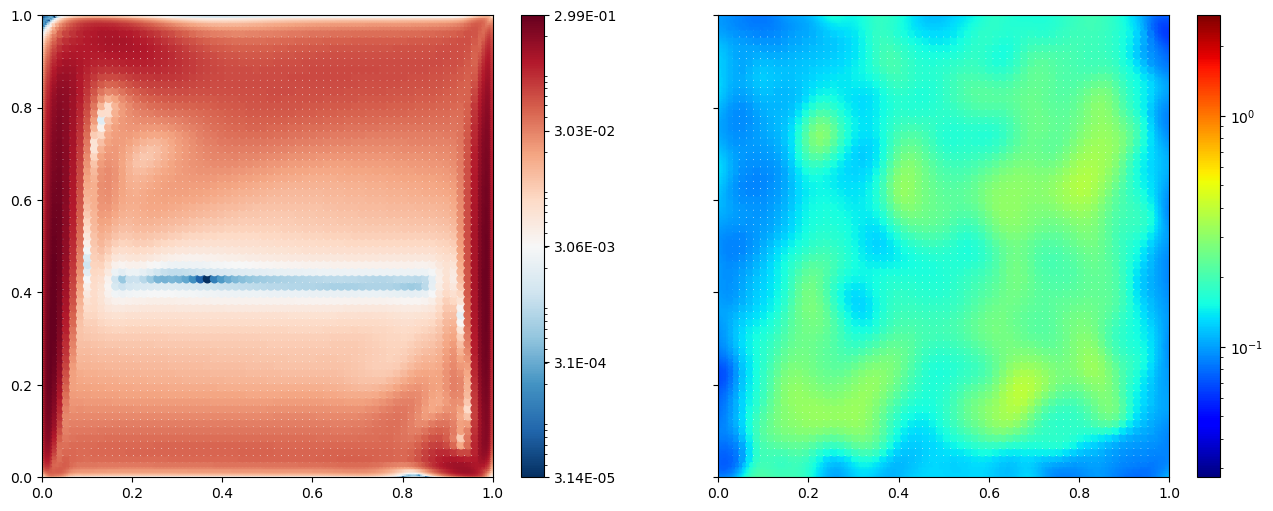

individual expert usage: ['1.27E-01', '1.15E-01', '2.1E-01', '2.67E-01', '1.23E-01', '5.21E-02', '4.06E-02', '3.46E-02', '3.02E-02']
expert training after print False
expert training before validation False
expert training after validation False
Iter 20, expert mean 6.5E-02, lambda 1E+01, gate sigma 5E-02, lambda 1E+02 noisy gating 1.77E-02
Loss: 6.74E-06 = 6.09E-06 (objective) + 6.51E-07 (bandwidth penalty)
current validation RMSE:  0.002313855177068925
current learning rate:  1E-03
expert training before validation False
expert training after validation False
Iter 24, expert mean 6.5E-02, lambda 1E+01, gate sigma 5E-02, lambda 1E+02 noisy gating 1.25E-02
Loss: 7.61E-06 = 6.96E-06 (objective) + 6.51E-07 (bandwidth penalty)
current validation RMSE:  0.001951312507151112
current learning rate:  1E-03
expert training before validation False
expert training after validation False
Iter 28, expert mean 6.5E-02, lambda 1E+01, gate sigma 5E-02, lambda 1E+02 noisy gating 8.84E-03
Loss: 4.24E-0

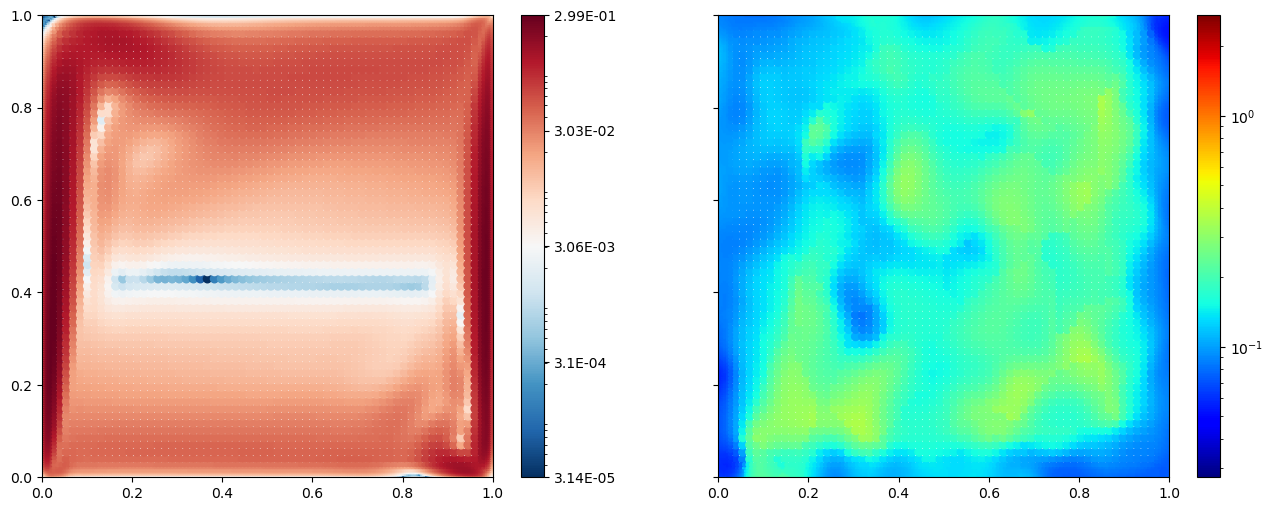

individual expert usage: ['1.08E-01', '1.23E-01', '2.31E-01', '3.15E-01', '1.12E-01', '3.75E-02', '3.09E-02', '2.53E-02', '1.7E-02']
expert training after print False
finalModel reached
expert training before validation False
expert training after validation False
Iter 40, expert mean 6.5E-02, lambda 1E+01, gate sigma 5E-02, lambda 1E+02 noisy gating 3.12E-03
Loss: 2.96E-06 = 2.29E-06 (objective) + 6.72E-07 (bandwidth penalty)
current validation RMSE:  0.0015398122185112267
current learning rate:  1E-03
expert training before validation False
expert training after validation False
expert training before validation False
expert training after validation False
Iter 44, expert mean 6.5E-02, lambda 1E+01, gate sigma 5E-02, lambda 1E+02 noisy gating 2.21E-03
Loss: 2.94E-06 = 2.26E-06 (objective) + 6.75E-07 (bandwidth penalty)
current validation RMSE:  0.0014824369019175389
current learning rate:  1E-03
expert training before validation False
expert training after validation False
expert tra

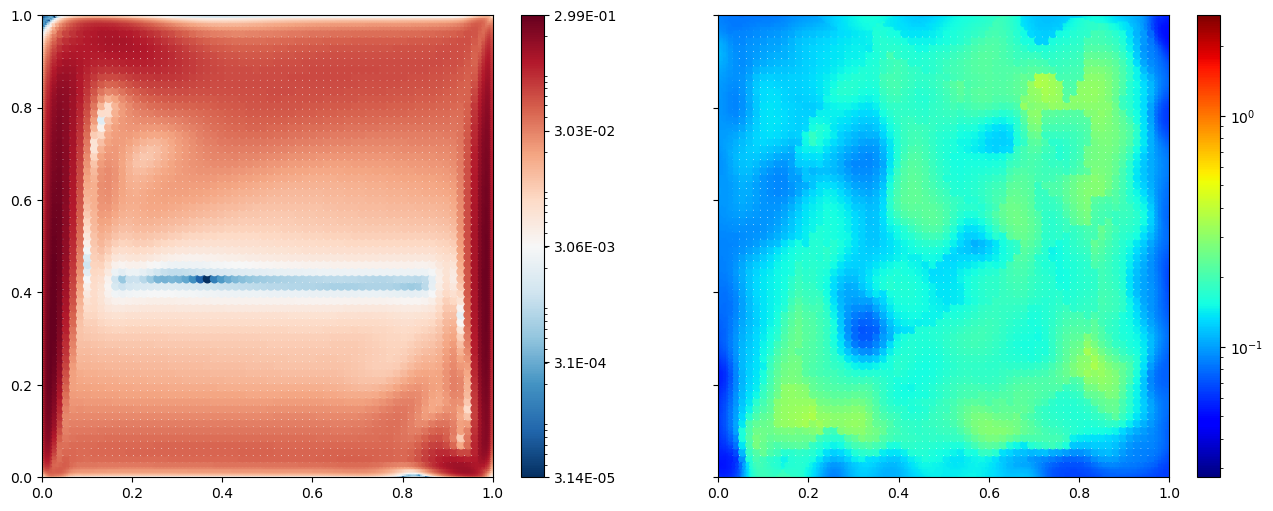

individual expert usage: ['9.48E-02', '1.34E-01', '2.32E-01', '3.54E-01', '1.05E-01', '2.59E-02', '2.43E-02', '1.89E-02', '1.17E-02']
expert training after print False
expert training before validation False
expert training after validation False
Iter 60, expert mean 6.5E-02, lambda 1E+01, gate sigma 5E-02, lambda 1E+02 noisy gating 5.52E-04
Loss: 2.57E-06 = 1.89E-06 (objective) + 6.82E-07 (bandwidth penalty)
current validation RMSE:  0.0013860323768156118
current learning rate:  1E-03
expert training before validation False
expert training after validation False
expert training before validation False
expert training after validation False
Iter 64, expert mean 6.5E-02, lambda 1E+01, gate sigma 5E-02, lambda 1E+02 noisy gating 3.91E-04
Loss: 1.81E-06 = 1.14E-06 (objective) + 6.72E-07 (bandwidth penalty)
current validation RMSE:  0.0013620458788115891
current learning rate:  1E-03
expert training before validation False
expert training after validation False
expert training before valid

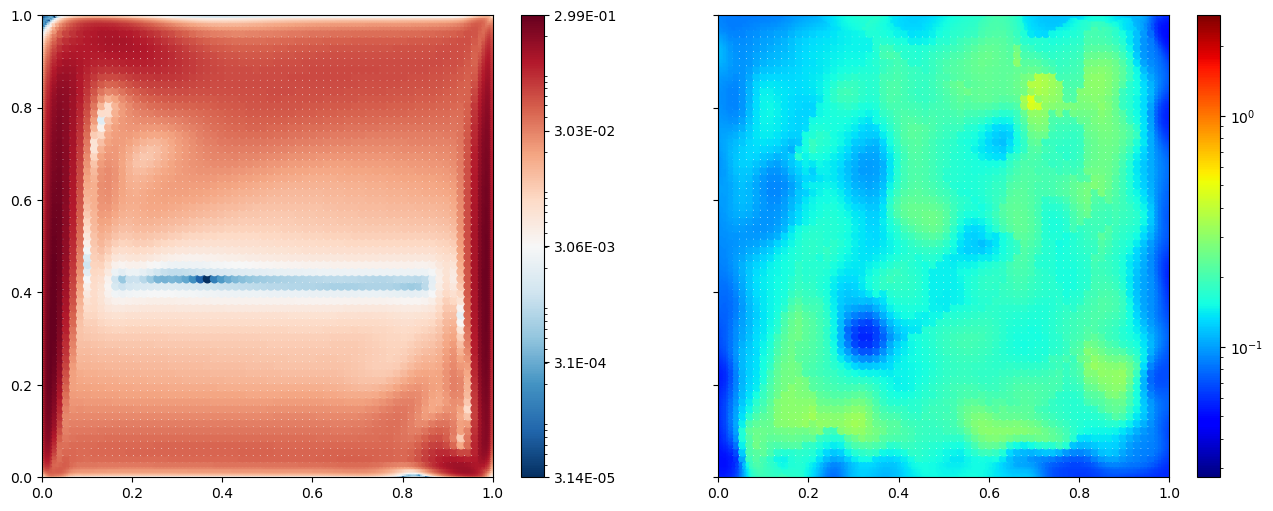

individual expert usage: ['8.25E-02', '1.47E-01', '2.27E-01', '3.65E-01', '1.01E-01', '2.37E-02', '2.47E-02', '1.83E-02', '1.13E-02']
expert training after print False
expert training before validation False
expert training after validation False
Iter 80, expert mean 6.5E-02, lambda 1E+01, gate sigma 5E-02, lambda 1E+02 noisy gating 9.77E-05
Loss: 2.07E-06 = 1.38E-06 (objective) + 6.92E-07 (bandwidth penalty)
current validation RMSE:  0.0013128098486355718
current learning rate:  1E-03
expert training before validation False
expert training after validation False
expert training before validation False
expert training after validation False
Iter 84, expert mean 6.5E-02, lambda 1E+01, gate sigma 5E-02, lambda 1E+02 noisy gating 6.91E-05
Loss: 1.77E-06 = 1.09E-06 (objective) + 6.78E-07 (bandwidth penalty)
current validation RMSE:  0.001302739769638676
current learning rate:  1E-03
expert training before validation False
expert training after validation False
expert training before valida

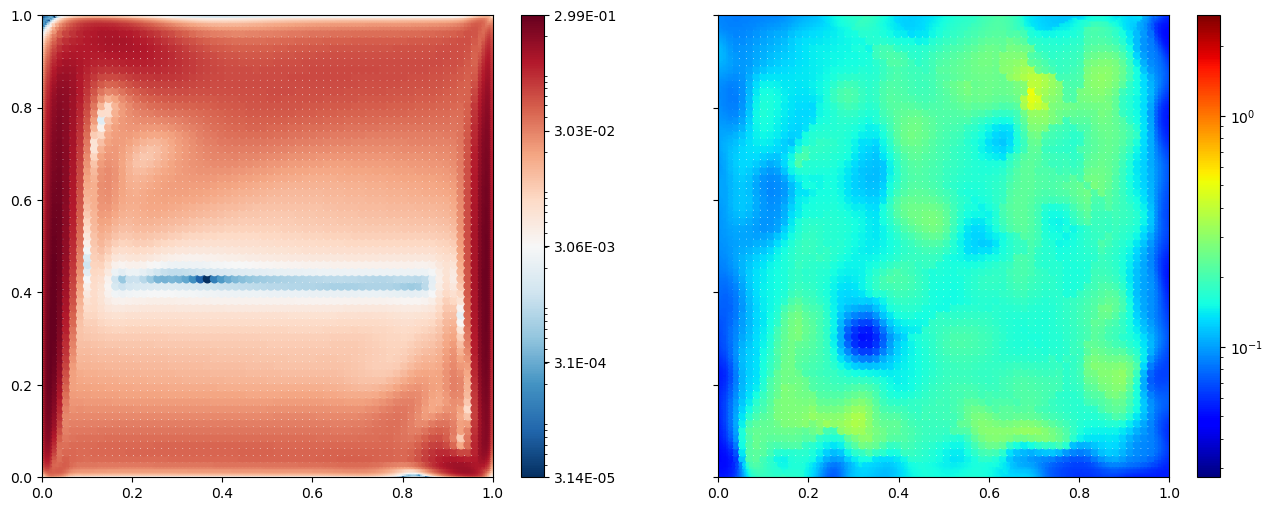

individual expert usage: ['7.12E-02', '1.59E-01', '2.19E-01', '3.75E-01', '9.79E-02', '2.28E-02', '2.49E-02', '1.79E-02', '1.15E-02']
expert training after print False
expert training before validation False
expert training after validation False
Iter 100, expert mean 6.5E-02, lambda 1E+01, gate sigma 5E-02, lambda 1E+02 noisy gating 1.73E-05
Loss: 1.66E-06 = 9.98E-07 (objective) + 6.66E-07 (bandwidth penalty)
current validation RMSE:  0.001258537741341264
current learning rate:  1E-03
expert training before validation False
expert training after validation False
expert training before validation False
expert training after validation False
Iter 104, expert mean 6.5E-02, lambda 1E+01, gate sigma 5E-02, lambda 1E+02 noisy gating 1.22E-05
Loss: 2.2E-06 = 1.52E-06 (objective) + 6.73E-07 (bandwidth penalty)
current validation RMSE:  0.001245614126708637
current learning rate:  1E-03
expert training before validation False
expert training after validation False
expert training before valida

KeyboardInterrupt: 

In [7]:
if testUniformly:
    testDensityPool = poolDensity*0+1
    testDensityPlot = densityPlot*0+1
else:
    testDensityPool = np.copy(poolDensity)
    testDensityPlot = np.copy(densityPlot)
testDensityNorm = np.mean(testDensityPool / poolDensity)
testDensityPool /= testDensityNorm
testDensityPlot /= testDensityNorm
if testUniformly:
    def testDensity(x, inputSpaceBounds):
        return np.ones(len(x)) / testDensityNorm
else:
    def testDensity(x, inputSpaceBounds):
        return poolDensityFunction(x, inputSpaceBounds) / testDensityNorm

def rdTest(size, nnPars, invalidPoolInx):
    return(myPoolSampling(size, testDensityPool, poolDensity, invalidPoolInx))
randTestDistribution = rdTest
    
if alPars['initialSamplingStrategy'] == 'uniform':
    pInitPool = poolDensity*0+1
    pInitPlot = densityPlot*0+1
    
    pInitNorm = np.mean(pInitPool / poolDensity)
    def pInit(x, inputSpaceBounds):
        return np.ones(len(x)) / pInitNorm
elif alPars['initialSamplingStrategy'] == 'pool':
    pInitPool = np.copy(poolDensity)
    pInitPlot = np.copy(densityPlot)
    
    pInitNorm = np.mean(pInitPool / poolDensity)
    def pInit(x, inputSpaceBounds):
        return poolDensityFunction(x, inputSpaceBounds) / pInitNorm
else:
    raise NotImplementedError
pInitPool /= pInitNorm
pInitPlot /= pInitNorm

if alPars['samplingAlgorithm'] == 'Random':
    def randPInit(size, invalidPoolInx):
        return(myPoolSampling(size=size, pTargetOfPool=pInitPool, pPoolofPool=poolDensity, invalidPoolInx=invalidPoolInx))
elif alPars['samplingAlgorithm'] == 'KMeans':
    def randPInit(size, invalidPoolInx):
        return(kMeansSamplingFromPool(size, xPool, pInitPool, poolDensity, invalidPoolInx, init_centers = ipSelectionPars['KMeansInit'], distributionalClustering = ipSelectionPars['KMeansDistributional'], max_iter = ipSelectionPars['KMeansMaxIter'], intrinsicDim = alPars['intrinsicDim']))
else:
    raise NotImplementedError

xRef = xPlot

resSABERopt_SABER = resultList(resultFile=resultFile, poolBased = True)

for rep in range(expPars['repetitions']):
    
    clear_output()    
    ####### set up global stuff for this repetition here (like validation and test data) ######
    if rep >= len(resSABERopt_SABER['allValInx']):
        seed = rep*(3*expPars['iters']+1)
        np.random.seed(seed)
        torch.manual_seed(seed+1)
        randInx = np.random.permutation(len(yPool))
        valInx = randInx[:expPars['validationSize']]
        testInx = randInx[expPars['validationSize']:(expPars['testSize']+expPars['validationSize'])]
    
        resSABERopt_SABER.update(rep, valInx = valInx, testInx = testInx)
        resSABERopt_SABER.save()
    else:
        valInx = resSABERopt_SABER['allValInx'][rep]
        testInx = resSABERopt_SABER['allTestInx'][rep]
    
    invalidPoolInx = np.concatenate((valInx, testInx))
    
    # since we draw validation and test at random in any case, we need importance weights for evaluation
    if testUniformly:
        iwVal = 1/poolDensity[valInx]
        iwVal /= np.mean(validationImportanceWeights)
        iwTest = 1/poolDensity[testInx]
        iwTest /= np.mean(testImportanceWeights)
    else:
        iwVal = np.ones(expPars['validationSize'])
        iwTest = np.ones(expPars['testSize'])
        
    validationX = xPool[valInx]
    validationY = yPool[valInx]

    xTest = xPool[testInx]
    yTest = yPool[testInx]
    
    # set up the learner
    saberAL = activeLearner(expPars, alPars, testDensity = testDensity, randTestDistribution = randTestDistribution, randPInit = randPInit, pInit = pInit, randUniform = randInputUnifFromDataset, xPool = xPool, yPool = yPool, densityPool = poolDensity, invalidPoolInx = invalidPoolInx, testDensityPool = testDensityPool, pInitPool = pInitPool, xRef = xRef)
        
    if rep < len(resSABERopt_SABER['allTrainInx']):
        # check if this repetition is fully calculated
        if len(resSABERopt_SABER['allTrainInx'][rep]) >= expPars['trainingSizes'][-1] and len(resSABERopt_SABER['allSABERmodelsStateDict']) > rep and len(resSABERopt_SABER['allSABERmodelsStateDict'][rep]) >= expPars['iters']:
            continue
        
        # load so far calculated data
        trainInx = resSABERopt_SABER['allTrainInx'][rep]
        saberAL.importPreviousData(xPool[trainInx], yPool[trainInx], trainInx = trainInx, densitiesInformation = resSABERopt_SABER['allDensitiesInformation'][rep])    

            
    j = 0
    n = expPars['trainingSizes'][j]

    ##### sample a new batch according to current optimal density proposal ###########
    seed = rep*(3*expPars['iters']+1) + j + 1
    np.random.seed(seed)
    torch.manual_seed(seed+1)
    if n > len(saberAL.X):

        # set up current training distribution
        saberAL.updateTrainingDistribution()

        sampleSize = n - len(saberAL.X)

        saberAL.growTrainingData(sampleSize)

        resSABERopt_SABER.update(rep, densitiesInformation = saberAL.densitiesInformation, trainInx = saberAL.trainInx)
        resSABERopt_SABER.save()

        saberAL.updateTrainImportanceWeights()
        
    #estimate pTrainPlot:
    pTrainPlot = pInitPlot
    if saberAL.alPars['updateTrainingDensity'] and len(saberAL.densitiesInformation) > 1:
        for i in range(len(saberAL.densitiesInformation) - 1):
            w = saberAL.densitiesInformation[i]['densityWeight']
            pTrainPlot = pTrainPlot * w + resSABERopt_SABER['allPlotInformation'][rep][i]['proposalDensityPlot'] * (1-w)

    # get the new IP selection strategies
    #inducing_point_method_expert, inducing_point_method_gate = defineIPsamplingMethod(saberAL, ipSelectionPars, alPars, modelPars, expertTrainingSubInx, gateTrainingSubInx)

    ipMetaSamplerPars = initIPsamplerPars(ipSelectionPars, alPars, modelPars)
    ipMetaSampler = inducingPointSampler(saberAL, pars = ipMetaSamplerPars)
    
    # if needed, estimate a global model to estimate shared expert parameters
    seed = rep*(3*expPars['iters']+1) + expPars['iters'] + j + 1
    np.random.seed(seed)
    torch.manual_seed(seed+1)
            
    if not alPars['noiseFree'] and not alPars['homoscedastic'] and localNoiseVariance is None:
        raise NotImplementedError
        # TODO: Need to provide a data-driven localNoiseVariance function estimate
        
    # define a global model and tune unspecified hyperparameters on validation set
    globalGPRpars = initGPRpars(modelPars, alPars)

    globalModel = globalGPR(saberAL.X, saberAL.y, iwTrain = saberAL.importanceWeights, lossFunction = None, pars = globalGPRpars, xVal = validationX, yVal = validationY, iwVal = iwVal, valLoss = expPars['valLoss'], localNoiseVariance = localNoiseVariance, labelModel = expPars['labelModel'], derivativeModel = expPars['derivativeModel'])

    # check if we already got a tuned global model
    if len(resSABERopt_SABER['allGlobalModelsStateDict']) > rep and len(resSABERopt_SABER['allGlobalModelsStateDict'][rep]) > j:
        globalStateDict = resSABERopt_SABER['allGlobalModelsStateDict'][rep][j]
    else:
        globalStateDict = None
    inducing_point_method_global = ipMetaSampler(IPstrategy = ipSelectionPars['IPstrategyExpert'])

    globalModel.init(inducing_points = None, inducing_point_method = inducing_point_method_global, modelStateDict = globalStateDict)
    if globalStateDict is None:
        globalModel.preTrainModel()
        globalModel.trainModel()

        resSABERopt_SABER.update(rep, globalModel_stateDict = globalModel.state_dict())
        resSABERopt_SABER.save()

    if len(resSABERopt_SABER['allGlobalTestErrors']) <= rep or len(resSABERopt_SABER['allGlobalTestErrors'][rep]) <= j:
        if len(xTest) > 0:
            with torch.no_grad():
                testPredGlobal = globalModel(torch.from_numpy(xTest).type(globalModel.y.dtype), predictionsOnly = True).mean
            testPredGlobal = testPredGlobal.numpy()
            testMAEglobal = np.mean(np.abs(testPredGlobal - fTest))
            testRMSEglobal = np.mean((testPredGlobal - fTest)**2)**0.5
            testMaxAEglobal = np.max(np.abs(testPredGlobal - fTest))
        else:
            testMAEglobal = np.double(np.nan)
            testRMSEglobal = np.double(np.nan)
            testMaxAEglobal = np.double(np.nan)

        globalTestErrors = {'RMSE': testRMSEglobal, 'MAE': testMAEglobal, 'maxAE': testMaxAEglobal}
            
        resSABERopt_SABER.update(rep, globalTestErrors = globalTestErrors)
        resSABERopt_SABER.save()

    print('median global RMSE')
    print(np.nanmedian(numpy_fillna([[err['RMSE'] for err in errors] for errors in resSABERopt_SABER['allGlobalTestErrors']]),0))
    print('median global MAE')
    print(np.nanmedian(numpy_fillna([[err['MAE'] for err in errors] for errors in resSABERopt_SABER['allGlobalTestErrors']]),0))
    print('median global max AE')
    print(np.nanmedian(numpy_fillna([[err['maxAE'] for err in errors] for errors in resSABERopt_SABER['allGlobalTestErrors']]),0))

    #TODO: transfer some globally estimated parameters to init SABER model
    SABERpars = initSABERpars(expPars, modelPars, alPars)
    
    # set up SABER model
    seed = rep*(3*expPars['iters']+1) + 2*expPars['iters'] + j + 1
    np.random.seed(seed)
    torch.manual_seed(seed+1)
    saberModel = SABER(saberAL.X, saberAL.y, iwTrain = saberAL.importanceWeights, lossFunction = None, pars = SABERpars, xVal = validationX, yVal = validationY, iwVal = iwVal, valLoss = expPars['valLoss'], localNoiseVariance = localNoiseVariance)

    saberModel.init(ipMetaSampler, ipSelectionPars, modelStateDict = None)
    saberModel.trainModel(printMethod = printSquareCavity, plotFrequencyFactor = modelPars['plotFrequencyFactor'])

    # estimate proposed superior training density (and some other intermediate results)
    saberAL.updateLocalProperties(saberModel.localBandwidthFunction, saberModel.localNoiseVarianceEstimate)

    # estimate local properties over xPlot for later visualization purpose
    plotInf = {}
    plotInf['trainingDensityPlot'] = pTrainPlot
    with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
        plotInf['sigmaPlot'] = saberAL.localBandwidthEstimate(xPlot)
        plotInf['complexityPlot'] = saberAL.localFunctionComplexityEstimate(xPlot, pCurrentOfX = pTrainPlot, bandwidthOfX = plotInf['sigmaPlot'])
        plotInf['proposalDensityPlot'] = saberAL.proposalDensityEstimate(xPlot, pCurrentOfX = pTrainPlot, q = testDensityPlot, lfc = plotInf['complexityPlot'])

    resSABERopt_SABER.update(rep, densitiesInformation = saberAL.densitiesInformation, SABERmodel_stateDict = saberModel.state_dict(), plotInformation = plotInf)
    resSABERopt_SABER.save()        
        
    if len(xTest) > 0:
        # measure performance
        with torch.no_grad():
            testPred, = saberModel(torch.from_numpy(xTest).type(saberModel.model.gate.variational_strategy.base_variational_strategy.inducing_points.dtype), predictionsOnly = True)
        testPred = testPred.numpy()

        testMAE = np.mean(np.abs(testPred - fTest))
        testRMSE = np.mean((testPred - fTest)**2)**0.5
        testMaxAE = np.max(np.abs(testPred - fTest))
    else:
        testMAE = np.double(np.nan)
        testRMSE = np.double(np.nan)
        testMaxAE = np.double(np.nan)
        
    testErrors = {'RMSE': testRMSE, 'MAE': testMAE, 'maxAE': testMaxAE}

    resSABERopt_SABER.update(rep, testErrors = testErrors)
    resSABERopt_SABER.save()

    print('median RMSE')
    print(np.nanmedian(numpy_fillna([[err['RMSE'] for err in errors] for errors in resSABERopt_SABER['allTestErrors']]),0))
    print('median MAE')
    print(np.nanmedian(numpy_fillna([[err['MAE'] for err in errors] for errors in resSABERopt_SABER['allTestErrors']]),0))
    print('median max AE')
#     print(np.nanmedian(numpy_fillna([[err['maxAE'] for err in errors] for errors in resSABERopt_SABER['allTestErrors']]),0))

In [7]:
# next: nnPars['expertBandwidths'] = 4 * 10**(np.linspace(-5/2+1/3 - 1/4,-5/2+1/3+7/4,9))
individual expert usage: ['1.02E-02', '1.41E-02', '2.14E-01', '2.46E-01', '1.41E-01', '1.05E-01', '1.05E-01', '8.04E-02', '8.32E-02']
Iter 116, expert mean 6.5E-02, lambda 1E+01, gate sigma 5E-02, lambda 1E+02 noisy gating 4.32E-06
Loss: 1.68E-06 = 1.19E-06 (objective) + 4.94E-07 (bandwidth penalty)
current validation RMSE:  0.0009892526851908766
current learning rate:  1.56E-04

array([ 0.1       ,  0.17782794,  0.31622777,  0.56234133,  1.        ,
        1.77827941,  3.16227766,  5.62341325, 10.        ])

0.012


/tmp/ipykernel_14227/2059952929.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt0 = axes[0].scatter(inducing_points[:,0], inducing_points[:,1], s=4/testDensity(inducing_points, inputSpaceBounds), cmap="RdBu_r")


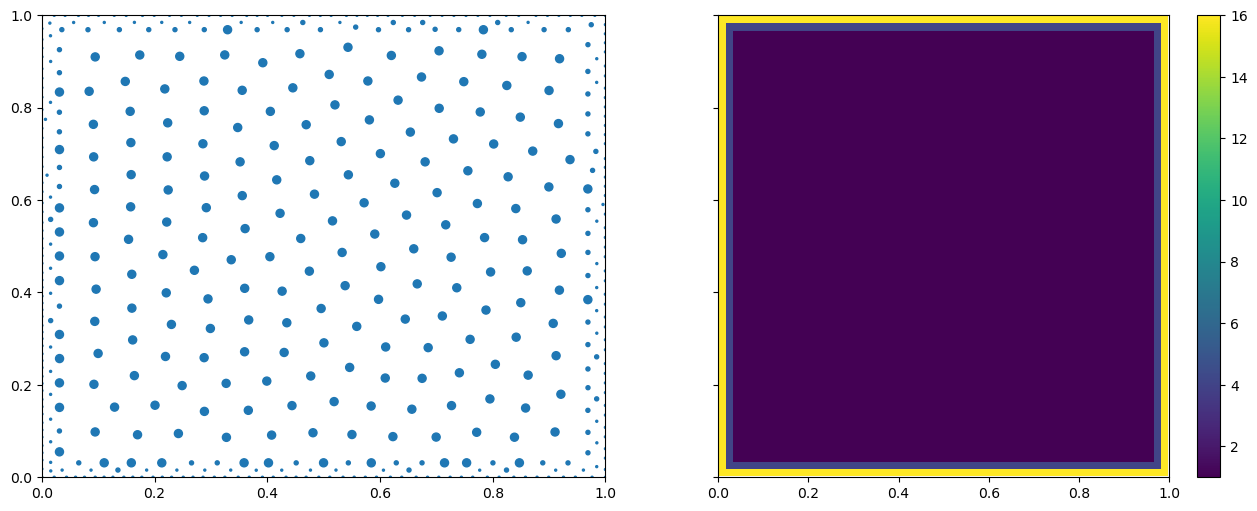

[3357.12 1119.04 4131.84]
(array([ 1,  4, 16]), array([3600,  976, 4032]))


In [56]:
nExpert = len(saberAL.X)
numExpertInducingPoints = 500

sigSVGD = saberAL.nnPars['svgdSigma']*(numExpertInducingPoints/saberAL.nnPars['svgdIPrefSize'])**(-1/saberAL.inputDim)
print(sigSVGD)
inxes = np.random.choice(np.arange(nExpert), numExpertInducingPoints, replace = False)
def pInducingPoints(x, inputSpaceBounds):
    return(saberAL.pCurrent(x))

from svgd import SVGD
inducing_points = SVGD().update(saberAL.xExpert[inxes], fixedIndices = None, prob = pInducingPoints, lnprob = None, inputSpaceBounds = saberAL.inputSpaceBounds, bandwidth = sigSVGD, stepsize = saberAL.nnPars['svgdInitStepSize'], terminalStepsize = saberAL.nnPars['svgdFinalStepSize'], repulsionPropToDensity = saberAL.nnPars['svgdRepulsionPropToDensity'], version=saberAL.nnPars['svgdVersion'], n_iter = saberAL.nnPars['svgdIters'])
fig, axes = plt.subplots(1, 2, sharex = True,sharey=True)
fig.set_figheight(6)
fig.set_figwidth(16)
plt0 = axes[0].scatter(inducing_points[:,0], inducing_points[:,1], s=4/testDensity(inducing_points, inputSpaceBounds), cmap="RdBu_r")

#plt1 = axes[1].scatter(xPlot[:,0], xPlot[:,1], c=poolDensity(xPlot, inputSpaceBounds), norm=colors.LogNorm(vmin=min(poolDensity(xPlot, inputSpaceBounds)), vmax=max(poolDensity(xPlot, inputSpaceBounds))), s=4/densityPlot, cmap="RdBu_r")
#cbar0 = plt.colorbar(plt1,ax=axes[1])

h = axes[1].hist2d(xPlot[:,0], xPlot[:,1], bins = bins)
plt.colorbar(h[3],ax=axes[1])

if np.ndim(axes) == 0:
    axes.set_xlim((0,1))
    axes.set_ylim((0,1))
elif np.ndim(axes) == 1:
    for bb in axes:
        bb.set_xlim((0,1))
        bb.set_ylim((0,1))
else:
    for aa in axes:
        for bb in aa:
            bb.set_xlim((0,1))
            bb.set_ylim((0,1))
plt.draw()
plt.pause(2)
plt.close(fig)

arr = (testDensity(inducing_points, inputSpaceBounds)/testDensity(inducing_points, inputSpaceBounds).min()).astype(int)
print(np.unique(arr, return_counts=True)[1] / len(inducing_points) * len(xPool))

arr = (testDensity(xPool, inputSpaceBounds)/testDensity(xPool, inputSpaceBounds).min()).astype(int)
print(np.unique(arr, return_counts=True))

Training sets of experts and gate will be shared


/tmp/ipykernel_8212/1627081959.py:178: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt0 = axes[0].scatter(inducing_points[:,0], inducing_points[:,1], s=4/testDensity(inducing_points, inputSpaceBounds), cmap="RdBu_r")


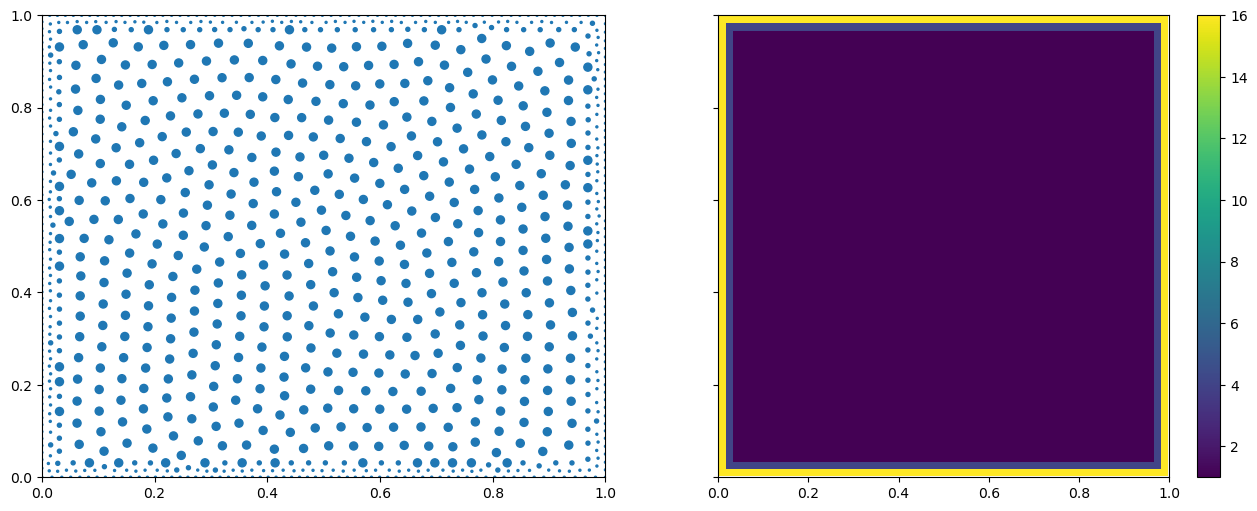

In [6]:
# specify hyperparameters
Q = 1
useXRef = True
updateTrainingDensity = True

refTrainSize = 6000
validationSize = len(xPlot) - refTrainSize
testSize = 0

##### SABER hyperparameters ################
# learning rate ############################
nnPars = initNNPars()

nnPars['lrPre'] = 1e-1
nnPars['lr'] = 2e-2
nnPars['lrGate'] = 2e-3

nnPars['expertModel'] = 'fullGP'

nnPars['min_lr'] = 1e-4
nnPars['lrFactorGPRhyperparameters'] = 5e-1
nnPars['lrFactorInducingPointDist'] = 1.
nnPars['lrFactorInducingPoints'] = 0. # I have no good experience with adapting inducing point positions at all

# training parameters
nnPars['loss'] = 'mse' #'mll'
nnPars['weightDecay'] = 0.
nnPars['validationFrequency'] = 4
nnPars['subValidationFrequency'] = 2
nnPars['baseBatchSize'] = int(2**8)
nnPars['EPOCH'] = 1000
nnPars['pretrainExpertEpochs'] = int(2**4)
nnPars['noiseFree'] = True
if nnPars['loss'] == 'mll':
    nnPars['smallBandwidthPenalty'] = 1e-2
    nnPars['unequalTrainingLoadPenalty'] = 1e-2
    nnPars['nonSparsenessPenalty'] = 1e1
if nnPars['loss'] == 'mse':
    nnPars['smallBandwidthPenalty'] = 1e-6
    nnPars['unequalTrainingLoadPenalty'] = 1e-5
    nnPars['nonSparsenessPenalty'] = 1e-3
nnPars['unequalExpertLambdaPenalty'] = 0.
nnPars['unequalExpertMeanPenalty'] = 0.
nnPars['unequalExpertNoisePenalty'] = 0.

# parameters adaption as training size grows
nnPars['pretrainExpertEpochsScalingExponent'] = -1.
nnPars['validationFrequencyScalingExponent'] = -0.5
nnPars['expertLambdaScalingExponent'] = -0.5
nnPars['expertBandwidthScalingExponent'] = -0.
nnPars['batchSizeScalingExponent'] = 0.
nnPars['expertInducingPointScalingExponent'] = 0.
nnPars['gateInducingPointScalingExponent'] = 0.

# inducing point initialization strategy
nnPars['inducingPointInitialization'] = 'SVGD' # 'SVGD', 'Random', 'KMeans'
# SVGD related parameters
nnPars['svgdSigma'] = 1e-2
nnPars['svgdIters'] = 200
nnPars['svgdInitStepSize'] = 1e-2
nnPars['svgdFinalStepSize'] = 1e-4
nnPars['svgdRepulsionPropToDensity'] = True
nnPars['svgdVersion'] = 'v2'

nnPars['KMeansInit'] = 'k-means++' # 'random', 'k-means++'
nnPars['KMeansMaxIter'] = 300
nnPars['KMeansDistributional'] = True

# expert hyperparameters ####################
nnPars['fixedExpertLambda'] = False
nnPars['initialExpertLambda'] = 1e-2
nnPars['initExpertNoiseLevel'] = 1e0
nnPars['fixedExpertSigma'] = True
nnPars['fixedSharedExpertSigma'] = True
nnPars['expertBandwidths'] = 10**np.linspace(-12/8,-4/8,9)# 10**np.linspace(-5/3,0/3,6)
nnPars['numExpertInducingPoints'] = 1024
nnPars['fixedExpertInducingPoints'] = True

# gate hyperparameters ######################
nnPars['gateOutputType'] = 'independent' #'independent', 'dependent'
nnPars['gateSigma'] = 6e-2
nnPars['gateLambda'] = 1e-1
nnPars['fixedGateSigma'] = True
nnPars['fixedGateLambda'] = True
nnPars['numGateInducingPoints'] = 256
nnPars['fixedGateInducingPoints'] = True

# MOE hyperparameters
nnPars['shareExpertMeanFromValiationIteration'] = 0 # 0, 10, np.Inf, whether we share the mean from the beginning, after some iteration or never; while the latter ones are more flexible, the first option is most stable
nnPars['shareExpertLambdaFromValiationIteration'] = 0 # 0, 10, np.Inf, whether we share the lambda from the beginning, after some iteration or never; while the latter ones are more flexible, the first option is most stable
nnPars['shareExpertNoiseFromValiationIteration'] = 0 # like above; however I am confident about using 0 here
nnPars['expertHardSparsity'] = len(nnPars['expertBandwidths']) # the final maximal number of experts the gate chooses; note that for 1 expert we loose continuity of the regressor
nnPars['expertSoftSparsity'] = len(nnPars['expertBandwidths'])
nnPars['sparsifySoftAfterValiationIterations'] = 2
nnPars['initSoftSparsificationAfterValiationIterations'] = 5
nnPars['sparsifyHardAfterValiationIterations'] = 2
nnPars['initHardSparsificationAfterValiationIterations'] = 10
nnPars['noisy_gating'] = True
nnPars['noisy_gating_b'] = True
nnPars['noisy_gating_w'] = False
nnPars['gate_noise_stdDev'] = 1e-1
nnPars['inducingCovarType'] = 'scalar' # 'scalar', 'diag' or 'full'

testDensityPlot = densityPlot
pCurrentPlot = densityPlot
rep = 0
####### set up global stuff for this repetition here (like validation and test data) ######
seed = 2*rep
np.random.seed(seed)
torch.manual_seed(seed+1)
# separate a validation set from training set
randInx = np.random.permutation(len(xPlot))
valInx = randInx[:validationSize]
testInx = randInx[validationSize:(validationSize+testSize)]
trainInx = randInx[(validationSize+testSize):]
validationX = xPlot[valInx]
validationY = yPlot[valInx]

if len(testInx) > 0:
    xTest = xPlot[testInx]
    fTest = yPlot[testInx]
else:
    xTest = validationX
    fTest = validationY

currentX = xPlot[trainInx]
currentY = yPlot[trainInx]
pCurrentTrain = pCurrentPlot[trainInx]
testDensityTrain = testDensityPlot[trainInx]
n = len(currentX)

trainImportanceWeights = testDensityTrain/pCurrentTrain
trainImportanceWeights *= n/np.sum(trainImportanceWeights)

saberAL = saberActiveLearner(nnPars, inputSpaceBounds, None, testDensity, None, refTrainSize, 0, (xPlot if useXRef else None), Q = Q, randPInit = None, pInit = testDensity, xVal = validationX, yVal = validationY)

saberAL.X = currentX
saberAL.y = currentY

# set up a dictionary for later reconstruction of local properties from intermediate iterations
densityInformation = {}
densityInformation['globalNoiseLevel'] = None
densityInformation['vRef'] = None
densityInformation['sigmaRef'] = None
densityInformation['complexityRef'] = None
if saberAL.xRef is None:
    densityInformation['trainingDensityRef'] = None
else:
    # before appending density information, the newest pNext is the actual training density at this point; after appending, pNext describes the next density
    densityInformation['trainingDensityRef'] = pCurrentPlot
densityInformation['trainSize'] = len(saberAL.X)
densityInformation['proposalDensityNormalization'] = 1.
densityInformation['proposalDensityRef'] = None
densityInformation['densityWeight'] = None
saberAL.densitiesInformation.append(densityInformation)

#saberAL.updateTrainImportanceWeights()
saberAL.importanceWeights = testDensityTrain/pCurrentTrain
saberAL.importanceWeights *= len(saberAL.X)/np.sum(saberAL.importanceWeights)


# init the inducing points as random subsample of training data
refInxes = np.random.choice(np.arange(saberAL.X.shape[0]), nnPars['numExpertInducingPoints'], replace=(False if saberAL.X.shape[0] >= nnPars['numExpertInducingPoints'] else True))
inducing_points = saberAL.X[refInxes]
if saberAL.X.shape[0] < nnPars['numExpertInducingPoints']:
    inducing_points += np.random.normal(0,0.01,inducing_points.shape)

from svgd import SVGD
sig = saberAL.nnPars['svgdSigma']*(saberAL.nnPars['numExpertInducingPoints']/512)**(-1/saberAL.inputDim)

def pCurrent(x, inputSpaceBounds):
    return(saberAL.pCurrent(x))
inducing_points = SVGD().update(inducing_points, fixedIndices = None, prob = pCurrent, lnprob = None, inputSpaceBounds = saberAL.inputSpaceBounds, bandwidth = sig, stepsize = saberAL.nnPars['svgdInitStepSize'], terminalStepsize = saberAL.nnPars['svgdFinalStepSize'], repulsionPropToDensity = saberAL.nnPars['svgdRepulsionPropToDensity'], version=saberAL.nnPars['svgdVersion'], n_iter = saberAL.nnPars['svgdIters'])

fig, axes = plt.subplots(1, 2, sharex = True,sharey=True)
fig.set_figheight(6)
fig.set_figwidth(16)
plt0 = axes[0].scatter(inducing_points[:,0], inducing_points[:,1], s=4/testDensity(inducing_points, inputSpaceBounds), cmap="RdBu_r")

#plt1 = axes[1].scatter(xPlot[:,0], xPlot[:,1], c=poolDensity(xPlot, inputSpaceBounds), norm=colors.LogNorm(vmin=min(poolDensity(xPlot, inputSpaceBounds)), vmax=max(poolDensity(xPlot, inputSpaceBounds))), s=4/densityPlot, cmap="RdBu_r")
#cbar0 = plt.colorbar(plt1,ax=axes[1])

h = axes[1].hist2d(xPlot[:,0], xPlot[:,1], bins = bins)
plt.colorbar(h[3],ax=axes[1])

if np.ndim(axes) == 0:
    axes.set_xlim((0,1))
    axes.set_ylim((0,1))
elif np.ndim(axes) == 1:
    for bb in axes:
        bb.set_xlim((0,1))
        bb.set_ylim((0,1))
else:
    for aa in axes:
        for bb in aa:
            bb.set_xlim((0,1))
            bb.set_ylim((0,1))
plt.draw()
plt.pause(2)
plt.close(fig)

In [6]:
# specify hyperparameters
######### TODO reasonable value for Q (e.g. Q = Inf)? #####################
Q = 1
homoscedastic = True
useXRef = True
refTrainSize = 7*1024
validationSize = len(xPlot) - refTrainSize
testSize = len(xPlot) - refTrainSize - validationSize

##### SABER hyperparameters ################
# learning rate ############################
nnPars = {}
nnPars['lrPre'] = 1e-1
nnPars['lr'] = 2e-2
nnPars['lrGate'] = 2e-3

nnPars['min_lr'] = 1e-4
nnPars['lrFactorGPRhyperparameters'] = 5e-1
nnPars['lrFactorInducingPointDist'] = 1.
nnPars['lrFactorInducingPoints'] = 0. # I have no good experience with adapting inducing point positions at all

# training parameters
nnPars['loss'] = 'mse' #'mll'
nnPars['weightDecay'] = 0.
nnPars['validationFrequency'] = 4
nnPars['baseBatchSize'] = int(2**8)
nnPars['EPOCH'] = 1000
nnPars['pretrainExpertEpochs'] = int(2**4)
if nnPars['loss'] == 'mll':
    nnPars['smallBandwidthPenalty'] = 1e-2
    nnPars['unequalTrainingLoadPenalty'] = 1e-2
    nnPars['nonSparsenessPenalty'] = 1e1
if nnPars['loss'] == 'mse':
    nnPars['smallBandwidthPenalty'] = 1e-6
    nnPars['unequalTrainingLoadPenalty'] = 1e-5
    nnPars['nonSparsenessPenalty'] = 1e-3
    
nnPars['unequalExpertLambdaPenalty'] = 0.
nnPars['unequalExpertMeanPenalty'] = 0.
nnPars['unequalExpertNoisePenalty'] = 0.

# parameters adaption as training size grows
nnPars['pretrainExpertEpochsScalingExponent'] = -1.
nnPars['validationFrequencyScalingExponent'] = -0.5
nnPars['expertLambdaScalingExponent'] = -0.5
nnPars['expertBandwidthScalingExponent'] = -0.
nnPars['batchSizeScalingExponent'] = 0.
nnPars['expertInducingPointScalingExponent'] = 0.
nnPars['gateInducingPointScalingExponent'] = 0.

# inducing point initialization strategy
nnPars['inducingPointInitialization'] = 'SVGD' # 'SVGD', 'Random', 'KMeans'
# SVGD related parameters
nnPars['svgdSigma'] = 1e-2
nnPars['svgdIters'] = 200
nnPars['svgdInitStepSize'] = 1e-2
nnPars['svgdFinalStepSize'] = 1e-4
nnPars['svgdRepulsionPropToDensity'] = True
nnPars['svgdVersion'] = 'v2'

nnPars['KMeansInit'] = 'k-means++' # 'random', 'k-means++'
nnPars['KMeansMaxIter'] = 300
nnPars['KMeansDistributional'] = True

# expert hyperparameters ####################
nnPars['fixedExpertLambda'] = False
nnPars['initialExpertLambda'] = 1e-2
nnPars['initExpertNoiseLevel'] = 1e0
nnPars['fixedExpertSigma'] = True
nnPars['fixedSharedExpertSigma'] = True
nnPars['expertBandwidths'] = 10**np.linspace(-12/8,-4/8,9)
nnPars['numExpertInducingPoints'] = 1024
nnPars['fixedExpertInducingPoints'] = True

# gate hyperparameters ######################
nnPars['gateOutputType'] = 'independent' #'independent', 'dependent'
nnPars['gateSigma'] = 6e-2
nnPars['gateLambda'] = 1e-1
nnPars['fixedGateSigma'] = True
nnPars['fixedGateLambda'] = True
nnPars['numGateInducingPoints'] = 256
nnPars['fixedGateInducingPoints'] = True

# MOE hyperparameters
nnPars['shareExpertMeanFromValiationIteration'] = 0 # 0, 10, np.Inf, whether we share the mean from the beginning, after some iteration or never; while the latter ones are more flexible, the first option is most stable
nnPars['shareExpertLambdaFromValiationIteration'] = 0 # 0, 10, np.Inf, whether we share the lambda from the beginning, after some iteration or never; while the latter ones are more flexible, the first option is most stable
nnPars['shareExpertNoiseFromValiationIteration'] = 0 # like above; however I am confident about using 0 here
nnPars['expertHardSparsity'] = 3 # the final maximal number of experts the gate chooses; note that for 1 expert we loose continuity of the regressor
nnPars['expertSoftSparsity'] = 2
nnPars['sparsifySoftAfterValiationIterations'] = 2
nnPars['initSoftSparsificationAfterValiationIterations'] = 5
nnPars['sparsifyHardAfterValiationIterations'] = 2
nnPars['initHardSparsificationAfterValiationIterations'] = 10
nnPars['noisy_gating'] = True
nnPars['noisy_gating_b'] = True
nnPars['noisy_gating_w'] = False
nnPars['gate_noise_stdDev'] = 1e-1
nnPars['inducingCovarType'] = 'scalar' # 'scalar', 'diag' or 'full'

# I have tuned the params for 512 inducing points. Thus we need to adapt sigma, if we change this number
nnPars['svgdSigma'] *= (nnPars['numExpertInducingPoints']/512)**(-1/inputDim)
        
ipInitString = '_ipInit' + nnPars['inducingPointInitialization']
if nnPars['inducingPointInitialization'] == 'SVGD':
    ipInitString += myScientificFormat(nnPars['svgdSigma'])
if nnPars['inducingPointInitialization'] == 'KMeans':
    if nnPars['KMeansInit'] == 'k-means++':
        ipInitString += 'Plus'
    if not nnPars['independentGateInducingPoints']:
        ipInitString += '_coupled'
        
expertString = '_expert'
# the expert IP description
expertString += '_IP'+str(nnPars['numExpertInducingPoints']) + ('_scaling'+myScientificFormat(nnPars['expertInducingPointScalingExponent']) if nnPars['expertInducingPointScalingExponent'] > 0 else '') + ('' if nnPars['fixedExpertInducingPoints'] else '_adaptive')
    
expertString += '_lambdaInit' + myScientificFormat(nnPars['initialExpertLambda']) + ('_individual' if nnPars['shareExpertLambdaFromValiationIteration'] == np.Inf else '')

expertString += '_sigRange' + myScientificFormat(nnPars['expertBandwidths'][0]) + 'to' + myScientificFormat(nnPars['expertBandwidths'][-1]) + '_' + str(len(nnPars['expertBandwidths'])) + ('_scaling' + myScientificFormat(-nnPars['expertBandwidthScalingExponent']) if nnPars['expertBandwidthScalingExponent'] < 0 else '') + ('' if nnPars['fixedSharedExpertSigma'] else '_tunable')

gateString = '_gate'
gateString += '_IP'+str(nnPars['numGateInducingPoints']) + ('' if nnPars['fixedGateInducingPoints'] else '_adaptive')
gateString += '_lambda' + myScientificFormat(nnPars['gateLambda'])
gateString += '_sigma' + myScientificFormat(nnPars['gateSigma'])
    
learningParametersString = '_eLR' + myScientificFormat(nnPars['lr']) + '_gLR' + myScientificFormat(nnPars['lrGate']) + '_batch' + str(nnPars['baseBatchSize']) + ('_scaling' + myScientificFormat(nnPars['batchSizeScalingExponent']) if nnPars['batchSizeScalingExponent'] > 0 else '') + '_gNoise' + myScientificFormat(nnPars['gate_noise_stdDev'])

penaltyString = '_pen'
penaltyString += '_load' + myScientificFormat(nnPars['unequalTrainingLoadPenalty'])
penaltyString += '_sig' + myScientificFormat(nnPars['smallBandwidthPenalty'])
penaltyString += '_sparse' + myScientificFormat(nnPars['nonSparsenessPenalty']) + '_' + str(nnPars['expertHardSparsity']) + '_' + str(nnPars['expertSoftSparsity'])
    
filename = dataName + '_SABER_'+str(Q) + expertString + gateString + ipInitString + learningParametersString + penaltyString

resultFile = os.path.join(saveDir, filename + '.tar')
resSABERopt_SABER = initResultListSABER(repetitions, 1, resultFile)

def printMethodSABER(saberAL, saberModel):
    fig, axes = plt.subplots(1, 2, sharex = True,sharey=True)
    fig.set_figheight(6)
    fig.set_figwidth(16)
    plt0 = axes[0].scatter(xPlot[:,0], xPlot[:,1], c=yPlot.flat, norm=colors.LogNorm(vmin=min(yPlot), vmax=max(yPlot)), s=4/densityPlot, cmap="RdBu_r")
    ticks = np.logspace(np.log10(min(yPlot)), np.log10(max(yPlot)), 5)
    cbar0 = plt.colorbar(plt0,ax=axes[0], ticks=ticks.ravel())
    null = cbar0.ax.set_yticklabels([myScientificFormat(a) for a in ticks.flat])
    
    saberModel.eval()
    with torch.no_grad():
        prediction, expert_output_distributions, gateValues, inxes, sigmaPlot = saberModel(torch.from_numpy(xPlot).float(), returnSigmaPredictions = True, combine = False)
    
    z1_plot = axes[1].scatter(xPlot[:,0], xPlot[:,1], c=sigmaPlot, s=4/densityPlot, cmap="jet", norm=colors.LogNorm(vmin=saberModel.expertBandwidths.numpy().min(), vmax=saberModel.expertBandwidths.numpy().max())) #norm=colors.LogNorm(vmin=min(sigmaPlot), vmax=max(sigmaPlot)))
    plt.colorbar(z1_plot,ax=axes[1])
    
    if np.ndim(axes) == 0:
        axes.set_xlim((0,1))
        axes.set_ylim((0,1))
    elif np.ndim(axes) == 1:
        for bb in axes:
            bb.set_xlim((0,1))
            bb.set_ylim((0,1))
    else:
        for aa in axes:
            for bb in aa:
                bb.set_xlim((0,1))
                bb.set_ylim((0,1))
    plt.draw()
    plt.pause(2)
    plt.close(fig)
    
    expertUsage = [vals.sum().item()/len(xPlot) for vals in gateValues]
    print('individual expert usage:', [myScientificFormat(u,2) for u in expertUsage])
    
    saberModel.train()

testDensityPlot = densityPlot
pCurrentPlot = densityPlot
rep = 0

####### set up global stuff for this repetition here (like validation and test data) ######
seed = 2*rep
np.random.seed(seed)
torch.manual_seed(seed+1)

# separate a validation set from training set
randInx = np.random.permutation(len(xPlot))
valInx = randInx[:validationSize]
testInx = randInx[validationSize:(validationSize+testSize)]
trainInx = randInx[(validationSize+testSize):]
validationX = xPlot[valInx]
validationY = yPlot[valInx]
if len(testInx) > 0:
    xTest = xPlot[testInx]
    fTest = yPlot[testInx]
else:
    xTest = validationX
    fTest = validationY

currentX = xPlot[trainInx]
currentY = yPlot[trainInx]
pCurrentTrain = pCurrentPlot[trainInx]
testDensityTrain = testDensityPlot[trainInx]
n = len(currentX)

trainImportanceWeights = testDensityTrain/pCurrentTrain
trainImportanceWeights *= n/np.sum(trainImportanceWeights)

# set up the learner
saberAL = saberActiveLearner(nnPars, inputSpaceBounds, None, testDensity, None, refTrainSize, (xPlot if useXRef else None), Q = Q, homoscedastic = homoscedastic, randPInit = None, pInit = testDensity, xVal = validationX, yVal = validationY)
# set up current training distribution
#saberAL.updateTrainingDistribution()

#saberAL.growTrainingData(batchSize)
saberAL.X = currentX
saberAL.y = currentY

# set up a dictionary for later reconstruction of local properties from intermediate iterations
densityInformation = {}
densityInformation['globalNoiseLevel'] = saberAL.globalNoiseLevel
densityInformation['vRef'] = None
densityInformation['sigmaRef'] = None
densityInformation['complexityRef'] = None
if saberAL.xRef is None:
    densityInformation['trainingDensityRef'] = None
else:
    # before appending density information, the newest pNext is the actual training density at this point; after appending, pNext describes the next density
    densityInformation['trainingDensityRef'] = pCurrentPlot
densityInformation['trainSize'] = len(saberAL.X)
densityInformation['proposalDensityNormalization'] = 1.
densityInformation['proposalDensityRef'] = None
densityInformation['densityWeight'] = None
saberAL.densitiesInformation.append(densityInformation)

#saberAL.updateTrainImportanceWeights()
saberAL.importanceWeights = testDensityTrain/pCurrentTrain
saberAL.importanceWeights *= len(saberAL.X)/np.sum(saberAL.importanceWeights)

######## estimate locally optimal bandwidths and new proposal density on reference data ####
seed = 2*rep + 1
np.random.seed(seed)
torch.manual_seed(seed+1)
initialExperts = saberAL.trainSABERModel(printMethod = printMethodSABER, onlyInitExperts = True)

batchSize:  256 , preTrainEpochs:  16 , inducing points:  1024 , lowerSig:  0.01778279410038923 , trainLoadPen:  1E-05 , nonSparsePen:  1E-03 , lambdaPen:  1E-01 , meanPen:  1E+00 , noisePen:  0E+00 , sigmaPen:  1E-06
find expert inducing points
initialize experts
expert 0
expert 1
expert 2
expert 3
expert 4
expert 5
expert 6


batchSize:  256 , preTrainEpochs:  16 , inducing points:  1024 , lowerSig:  0.01778279410038923 , trainLoadPen:  1E-05 , nonSparsePen:  1E-03 , lambdaPen:  1E-01 , meanPen:  1E+00 , noisePen:  0E+00 , sigmaPen:  1E-06
find expert inducing points
initialize experts
expert 0
expert 1
expert 2
expert 3
expert 4
expert 5
expert 6
load initial state_dict
start MoE training
Iter 0 , expert mean  -1.04E-02 , noise level  1E+00 , lambda  1.18E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.01E-01', '1.01E-01', '1.02E-01', '9.81E-02', '9.72E-02', '9.71E-02', '9.66E-02']
Loss: 3.38E-04 = 3.37E-04 (objective) + 1.02E-06 (bandwidth penalty) + 0E+00 (load penalty) + 0E+00 (non-sparseness penalty)
current validation RMSE:  0.02068220325189115
current learning rate:  2E-02


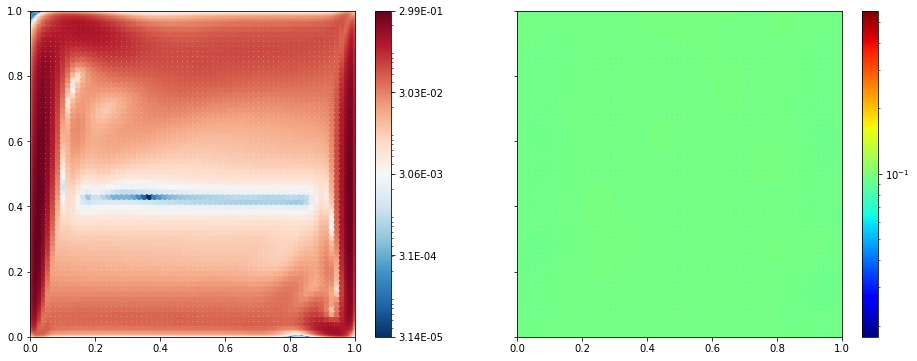

individual expert usage: ['1.49E-01', '1.49E-01', '1.48E-01', '1.39E-01', '1.38E-01', '1.38E-01', '1.38E-01']
Iter 4 , expert mean  -3.69E-02 , noise level  1E+00 , lambda  1.86E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['9.52E-02', '9.84E-02', '9.43E-02', '8.77E-02', '8.91E-02', '8.69E-02', '8.45E-02']
Loss: 1.2E-04 = 1.19E-04 (objective) + 1.07E-06 (bandwidth penalty) + 0E+00 (load penalty) + 0E+00 (non-sparseness penalty)
current validation RMSE:  0.011903951570264354
current learning rate:  2E-02


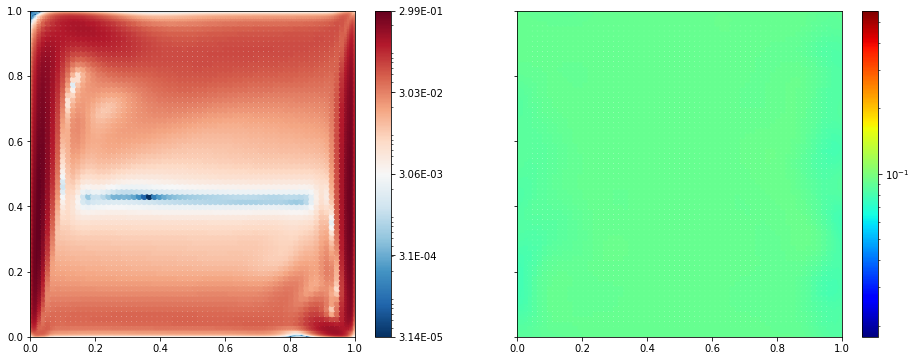

individual expert usage: ['1.73E-01', '1.64E-01', '1.44E-01', '1.27E-01', '1.3E-01', '1.31E-01', '1.31E-01']
Iter 8 , expert mean  -5.01E-02 , noise level  1E+00 , lambda  2.18E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['7.86E-02', '8.7E-02', '8.42E-02', '8.07E-02', '8.03E-02', '7.71E-02', '7.56E-02']
Loss: 6.47E-05 = 6.36E-05 (objective) + 1.09E-06 (bandwidth penalty) + 0E+00 (load penalty) + 0E+00 (non-sparseness penalty)
current validation RMSE:  0.008881694938451411
current learning rate:  2E-02


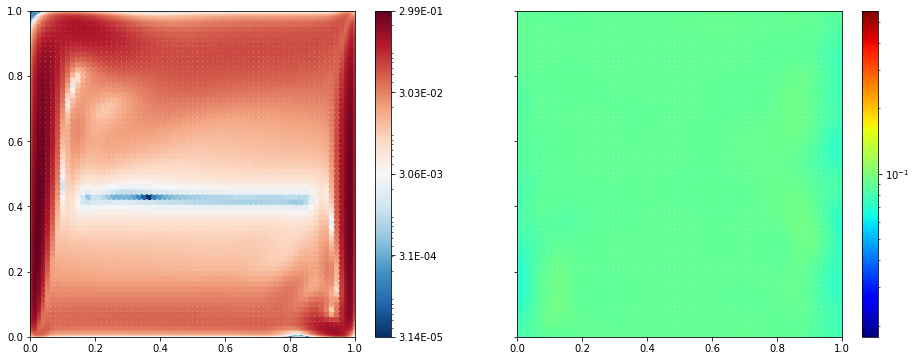

individual expert usage: ['1.88E-01', '1.62E-01', '1.37E-01', '1.25E-01', '1.29E-01', '1.29E-01', '1.3E-01']
Iter 12 , expert mean  -5.67E-02 , noise level  1E+00 , lambda  2.3E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['6.45E-02', '7.97E-02', '7.74E-02', '7.32E-02', '7.27E-02', '6.91E-02', '6.79E-02']
Loss: 5.13E-05 = 5.03E-05 (objective) + 1.08E-06 (bandwidth penalty) + 0E+00 (load penalty) + 0E+00 (non-sparseness penalty)
current validation RMSE:  0.008261307192575049
current learning rate:  2E-02


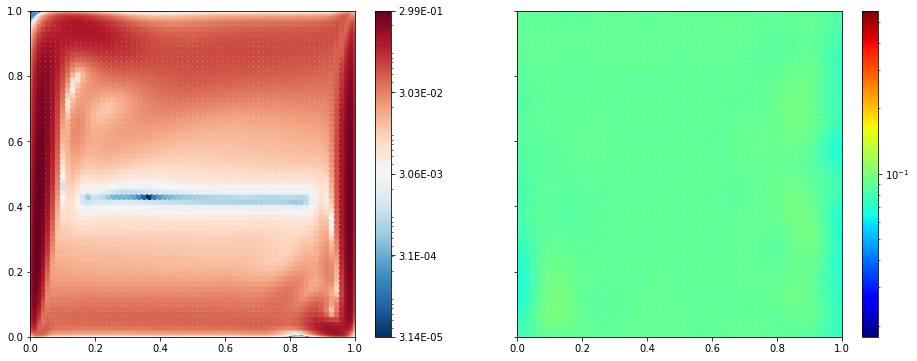

individual expert usage: ['1.95E-01', '1.59E-01', '1.36E-01', '1.24E-01', '1.28E-01', '1.29E-01', '1.29E-01']
Iter 16 , expert mean  -5.95E-02 , noise level  1E+00 , lambda  2.32E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['5.51E-02', '7.29E-02', '7.01E-02', '6.71E-02', '6.56E-02', '6.38E-02', '6.07E-02']
Loss: 6.17E-05 = 6.06E-05 (objective) + 1.09E-06 (bandwidth penalty) + 0E+00 (load penalty) + 0E+00 (non-sparseness penalty)
current validation RMSE:  0.007847870003749202
current learning rate:  2E-02


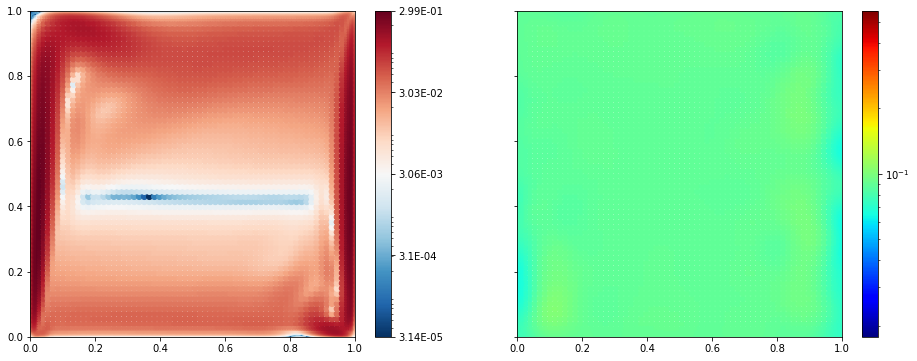

individual expert usage: ['1.96E-01', '1.57E-01', '1.37E-01', '1.24E-01', '1.28E-01', '1.29E-01', '1.29E-01']
Iter 20 , expert mean  -6.3E-02 , noise level  1E+00 , lambda  2.34E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['4.83E-02', '6.74E-02', '6.63E-02', '6.06E-02', '6.02E-02', '5.74E-02', '5.62E-02']
Loss: 4.74E-05 = 4.63E-05 (objective) + 1.09E-06 (bandwidth penalty) + 0E+00 (load penalty) + 0E+00 (non-sparseness penalty)
current validation RMSE:  0.007678578799214638
current learning rate:  2E-02


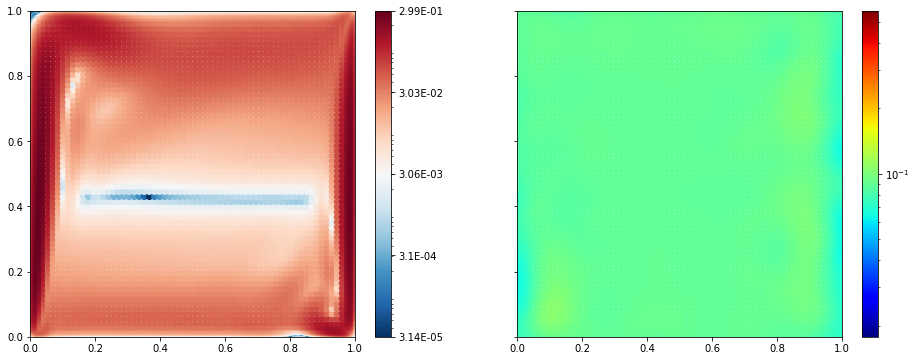

individual expert usage: ['1.97E-01', '1.56E-01', '1.39E-01', '1.24E-01', '1.28E-01', '1.29E-01', '1.28E-01']
Iter 24 , expert mean  -6.39E-02 , noise level  1E+00 , lambda  2.35E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['4.27E-02', '6.16E-02', '6.14E-02', '6.27E-02', '5.95E-02', '5.61E-02', '5.48E-02']
Loss: 1.65E-04 = 5.12E-05 (objective) + 1.1E-06 (bandwidth penalty) + 0E+00 (load penalty) + 1.12E-04 (non-sparseness penalty)
current validation RMSE:  0.007562368859276868
current learning rate:  2E-02


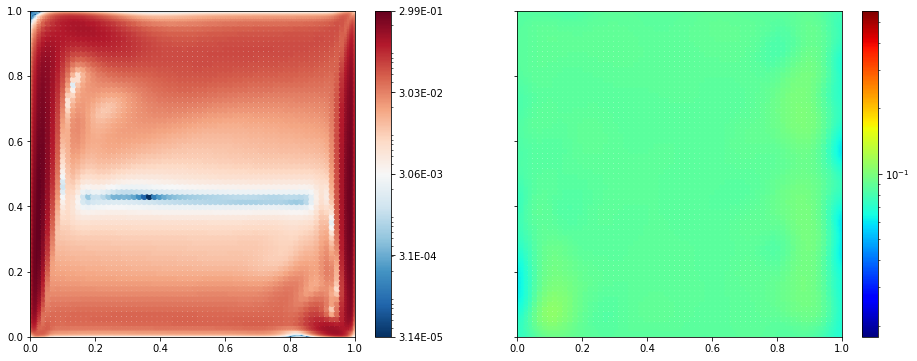

individual expert usage: ['2.01E-01', '1.59E-01', '1.47E-01', '1.15E-01', '1.24E-01', '1.28E-01', '1.26E-01']
Iter 28 , expert mean  -6.41E-02 , noise level  1E+00 , lambda  2.28E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['3.87E-02', '5.76E-02', '5.63E-02', '6.76E-02', '6.19E-02', '5.66E-02', '5.53E-02']
Loss: 1.23E-04 = 4.52E-05 (objective) + 1.14E-06 (bandwidth penalty) + 0E+00 (load penalty) + 7.69E-05 (non-sparseness penalty)
current validation RMSE:  0.007191770143318748
current learning rate:  2E-02


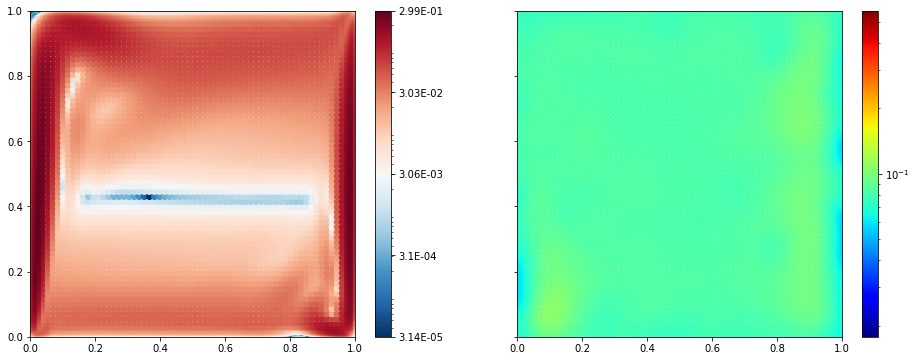

individual expert usage: ['2.06E-01', '1.7E-01', '1.82E-01', '7.71E-02', '1.17E-01', '1.26E-01', '1.22E-01']
Iter 32 , expert mean  -6.5E-02 , noise level  1E+00 , lambda  2.25E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['3.54E-02', '5.4E-02', '5.01E-02', '6.06E-02', '6E-02', '5.44E-02', '5.23E-02']
Loss: 1.26E-04 = 4.62E-05 (objective) + 1.17E-06 (bandwidth penalty) + 0E+00 (load penalty) + 7.83E-05 (non-sparseness penalty)
current validation RMSE:  0.006956906331663738
current learning rate:  2E-02


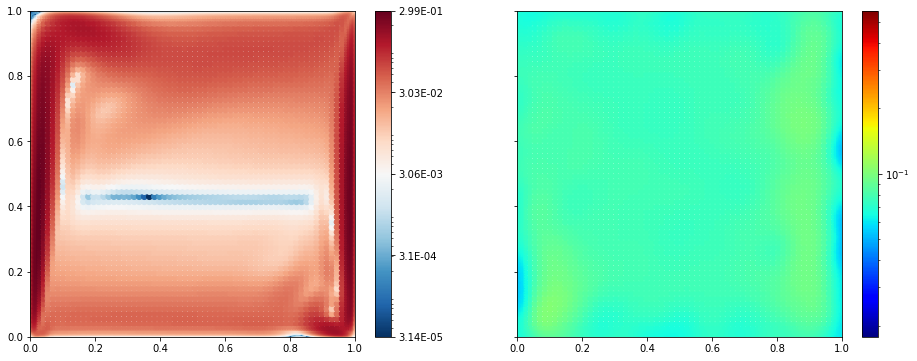

individual expert usage: ['2.02E-01', '1.72E-01', '2.38E-01', '5.86E-02', '1.01E-01', '1.18E-01', '1.1E-01']
Iter 36 , expert mean  -6.63E-02 , noise level  1E+00 , lambda  2.2E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['3.29E-02', '5.11E-02', '4.34E-02', '5.79E-02', '6.02E-02', '5.25E-02', '5.22E-02']
Loss: 8.77E-05 = 3.46E-05 (objective) + 1.24E-06 (bandwidth penalty) + 0E+00 (load penalty) + 5.18E-05 (non-sparseness penalty)
current validation RMSE:  0.006697225438536254
current learning rate:  2E-02


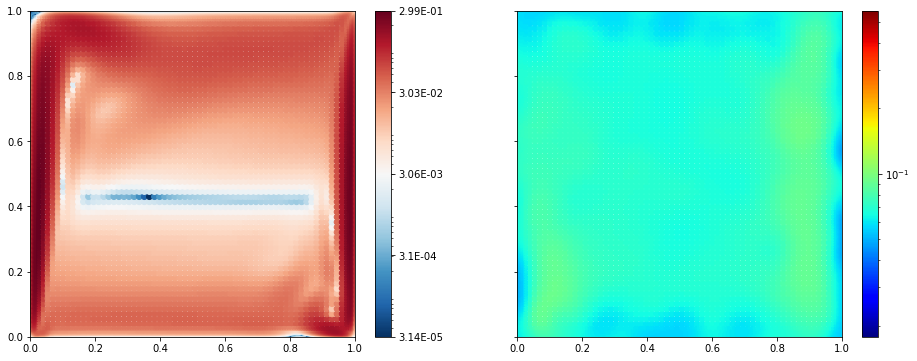

individual expert usage: ['1.82E-01', '1.59E-01', '3.65E-01', '4.34E-02', '6.22E-02', '1.01E-01', '8.75E-02']
Iter 40 , expert mean  -6.61E-02 , noise level  1E+00 , lambda  2.11E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['3.1E-02', '4.81E-02', '3.78E-02', '5.65E-02', '5.75E-02', '4.97E-02', '5.08E-02']
Loss: 1E-04 = 4.41E-05 (objective) + 1.28E-06 (bandwidth penalty) + 1.66E-06 (load penalty) + 5.31E-05 (non-sparseness penalty)
current validation RMSE:  0.006678052117711756
current learning rate:  2E-02


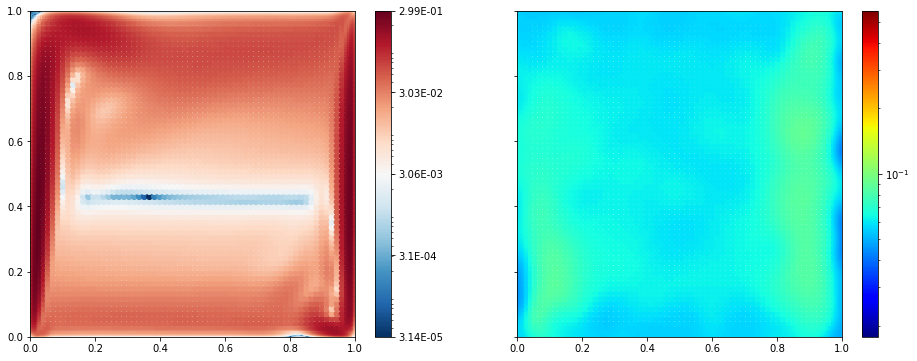

individual expert usage: ['1.55E-01', '1.33E-01', '5.25E-01', '0E+00', '4.14E-02', '8E-02', '6.52E-02']
Iter 44 , expert mean  -6.73E-02 , noise level  1E+00 , lambda  2.05E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['2.9E-02', '4.63E-02', '3.21E-02', '5.75E-02', '5.64E-02', '4.73E-02', '4.94E-02']
Loss: 7.69E-05 = 4.07E-05 (objective) + 1.33E-06 (bandwidth penalty) + 1.59E-06 (load penalty) + 3.33E-05 (non-sparseness penalty)
current validation RMSE:  0.006678103195467891
current learning rate:  2E-02


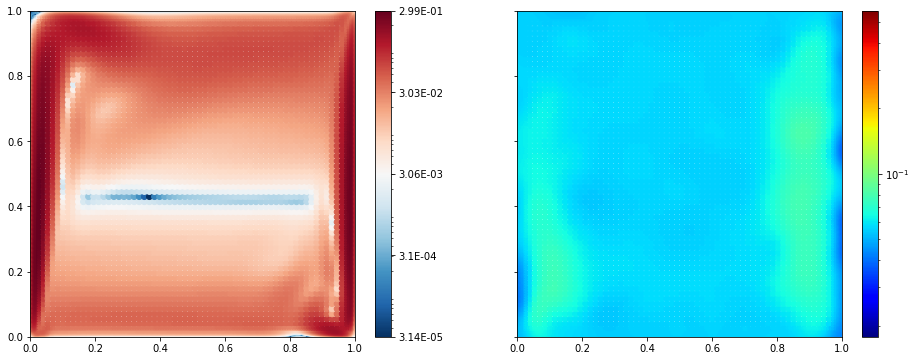

individual expert usage: ['1.3E-01', '1.1E-01', '6.37E-01', '0E+00', '2.74E-02', '5.88E-02', '3.75E-02']
Iter 48 , expert mean  -6.66E-02 , noise level  1E+00 , lambda  1.97E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['2.69E-02', '4.41E-02', '2.76E-02', '5.99E-02', '5.73E-02', '4.54E-02', '4.87E-02']
Loss: 7.12E-05 = 3.06E-05 (objective) + 1.36E-06 (bandwidth penalty) + 3.83E-06 (load penalty) + 3.54E-05 (non-sparseness penalty)
current validation RMSE:  0.005913516047839954
current learning rate:  2E-02


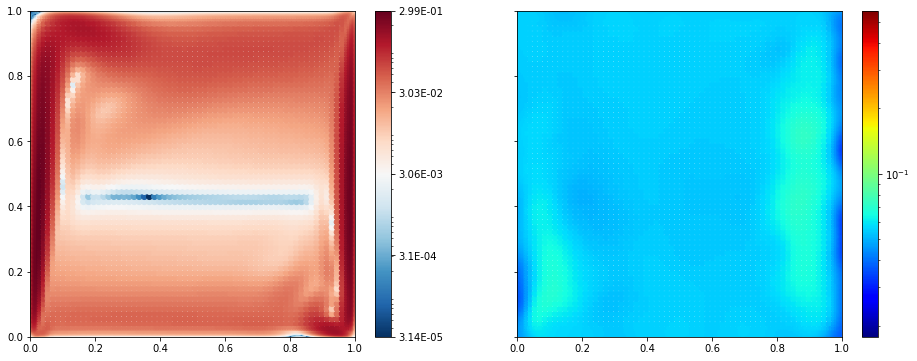

individual expert usage: ['1.16E-01', '9.76E-02', '7.16E-01', '0E+00', '3.91E-06', '4.48E-02', '2.57E-02']
Iter 52 , expert mean  -6.72E-02 , noise level  1E+00 , lambda  1.97E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['2.53E-02', '4.25E-02', '2.42E-02', '6E-02', '5.99E-02', '4.42E-02', '4.95E-02']
Loss: 4.73E-05 = 2.24E-05 (objective) + 1.38E-06 (bandwidth penalty) + 3.51E-06 (load penalty) + 2E-05 (non-sparseness penalty)
current validation RMSE:  0.005671169855223337
current learning rate:  2E-02


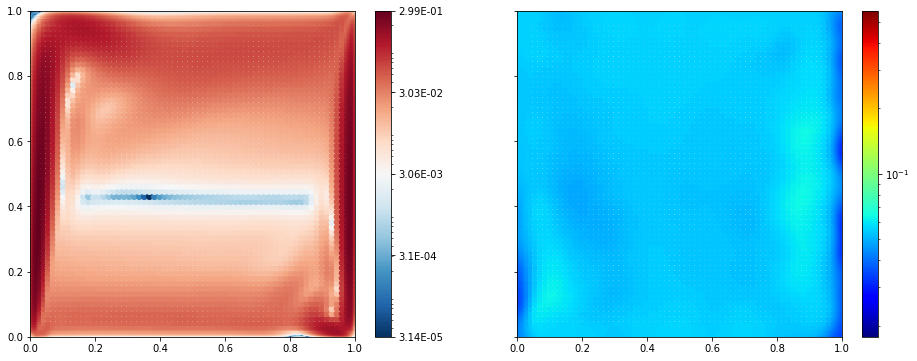

individual expert usage: ['1.03E-01', '9.04E-02', '7.62E-01', '0E+00', '9.51E-05', '2.7E-02', '1.75E-02']
Iter 56 , expert mean  -7.04E-02 , noise level  1E+00 , lambda  1.94E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['2.37E-02', '4.03E-02', '2.13E-02', '6.03E-02', '6.25E-02', '4.35E-02', '5.08E-02']
Loss: 7.48E-05 = 2.76E-05 (objective) + 1.41E-06 (bandwidth penalty) + 7.48E-06 (load penalty) + 3.83E-05 (non-sparseness penalty)
current validation RMSE:  0.0058177740247321846
current learning rate:  2E-02


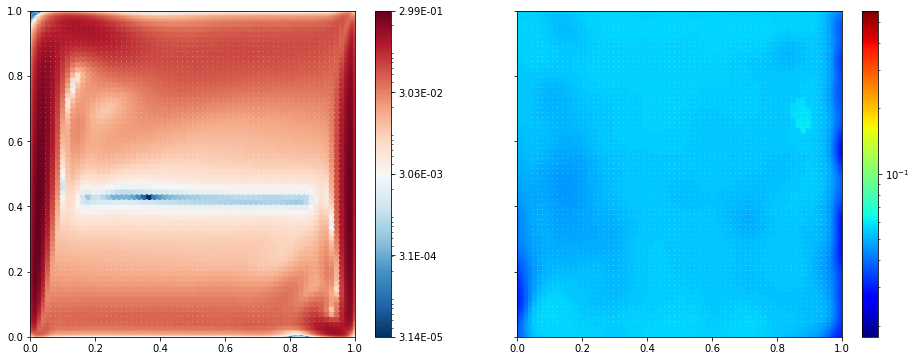

individual expert usage: ['9.58E-02', '7.75E-02', '8.08E-01', '0E+00', '0E+00', '1.87E-02', '4.78E-05']
Iter 60 , expert mean  -7.22E-02 , noise level  1E+00 , lambda  2E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['2.21E-02', '3.9E-02', '1.82E-02', '6.03E-02', '6.3E-02', '4.34E-02', '5.18E-02']
Loss: 6.46E-05 = 2.98E-05 (objective) + 1.4E-06 (bandwidth penalty) + 7.35E-06 (load penalty) + 2.6E-05 (non-sparseness penalty)
current validation RMSE:  0.005309908081156188
current learning rate:  2E-02


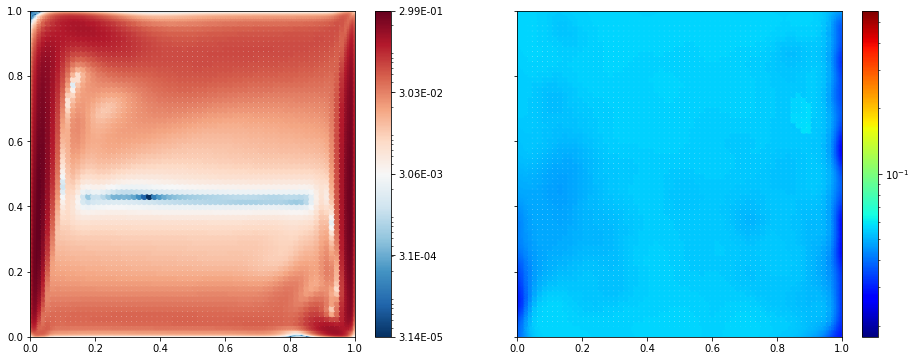

individual expert usage: ['9.14E-02', '5.51E-02', '8.4E-01', '0E+00', '0E+00', '1.34E-02', '2.28E-04']
Iter 64 , expert mean  -7.47E-02 , noise level  1E+00 , lambda  2.01E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['2.06E-02', '3.71E-02', '1.57E-02', '6.03E-02', '6.44E-02', '4.45E-02', '5.42E-02']
Loss: 7.89E-05 = 3.4E-05 (objective) + 1.4E-06 (bandwidth penalty) + 1.29E-05 (load penalty) + 3.06E-05 (non-sparseness penalty)
current validation RMSE:  0.005107611446436171
current learning rate:  2E-02


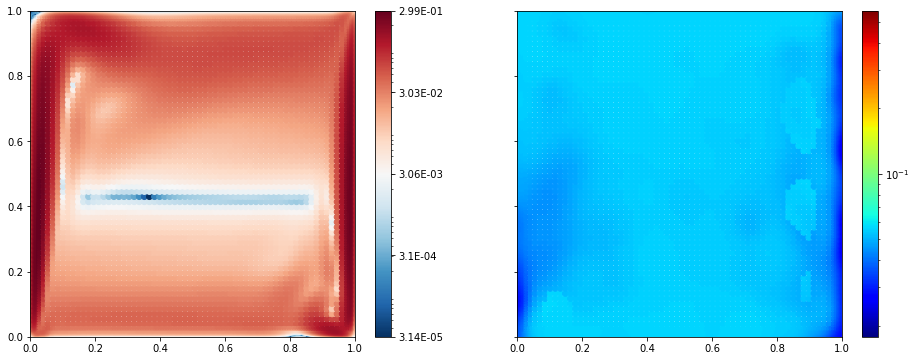

individual expert usage: ['8.99E-02', '4.15E-02', '8.68E-01', '0E+00', '0E+00', '6.47E-04', '0E+00']
Iter 68 , expert mean  -7.58E-02 , noise level  1E+00 , lambda  2.06E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.94E-02', '3.58E-02', '1.37E-02', '6.03E-02', '6.45E-02', '4.44E-02', '5.42E-02']
Loss: 6.02E-05 = 2.3E-05 (objective) + 1.4E-06 (bandwidth penalty) + 1.27E-05 (load penalty) + 2.3E-05 (non-sparseness penalty)
current validation RMSE:  0.005227923871908941
current learning rate:  2E-02


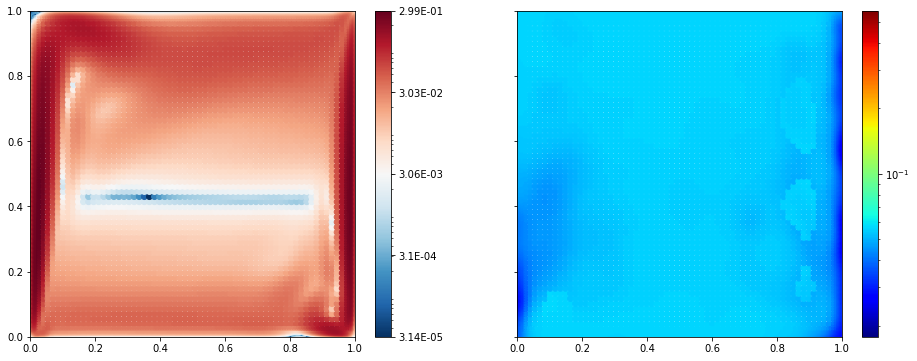

individual expert usage: ['8.77E-02', '2.94E-02', '8.82E-01', '0E+00', '0E+00', '6.61E-04', '0E+00']
Iter 72 , expert mean  -7.7E-02 , noise level  1E+00 , lambda  2.09E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.83E-02', '3.47E-02', '1.26E-02', '6.03E-02', '6.45E-02', '4.44E-02', '5.42E-02']
Loss: 5.36E-05 = 2.11E-05 (objective) + 1.39E-06 (bandwidth penalty) + 1.27E-05 (load penalty) + 1.84E-05 (non-sparseness penalty)
current validation RMSE:  0.005300380247043995
current learning rate:  2E-02


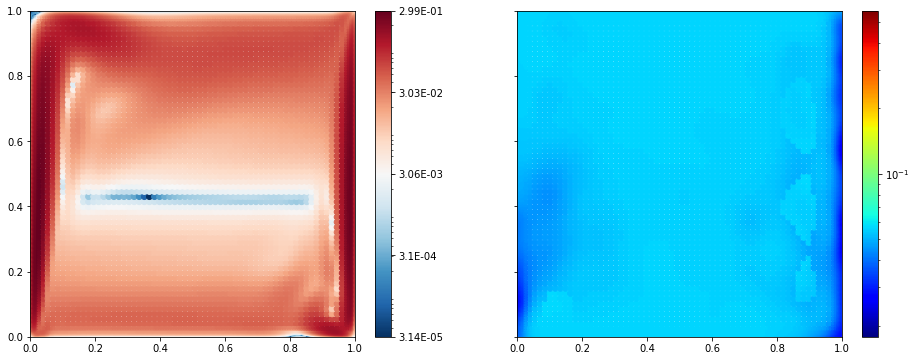

individual expert usage: ['8.63E-02', '2.32E-02', '8.9E-01', '0E+00', '0E+00', '6.91E-04', '0E+00']
Iter 76 , expert mean  -7.93E-02 , noise level  1E+00 , lambda  2.1E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.73E-02', '3.36E-02', '1.14E-02', '6.03E-02', '6.45E-02', '4.42E-02', '5.42E-02']
Loss: 5.1E-05 = 2.35E-05 (objective) + 1.4E-06 (bandwidth penalty) + 1.25E-05 (load penalty) + 1.36E-05 (non-sparseness penalty)
current validation RMSE:  0.004629776468372428
current learning rate:  2E-02


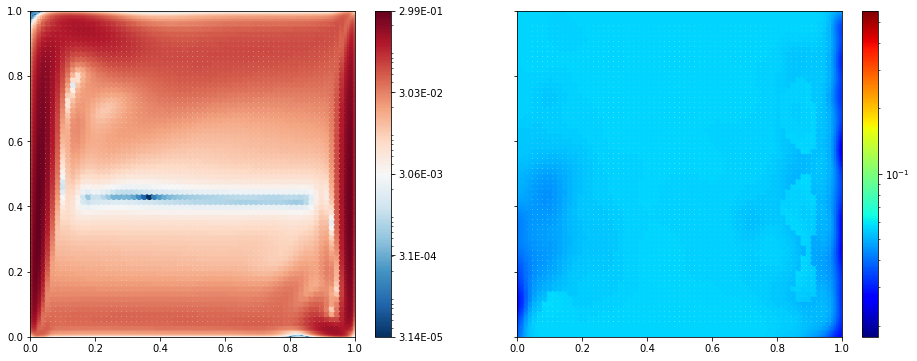

individual expert usage: ['8.49E-02', '1.89E-02', '8.95E-01', '0E+00', '0E+00', '7.1E-04', '0E+00']
Iter 80 , expert mean  -8.13E-02 , noise level  1E+00 , lambda  2.11E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.64E-02', '3.28E-02', '1.04E-02', '6.03E-02', '6.45E-02', '4.41E-02', '5.42E-02']
Loss: 4.4E-05 = 1.79E-05 (objective) + 1.39E-06 (bandwidth penalty) + 1.28E-05 (load penalty) + 1.19E-05 (non-sparseness penalty)
current validation RMSE:  0.0044640240409803056
current learning rate:  2E-02


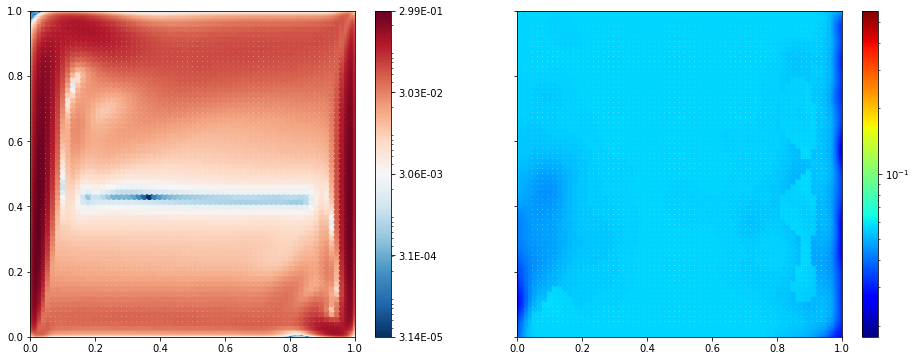

individual expert usage: ['8.37E-02', '1.59E-02', '9E-01', '0E+00', '0E+00', '7.28E-04', '0E+00']
Iter 84 , expert mean  -8.23E-02 , noise level  1E+00 , lambda  2.12E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.54E-02', '3.21E-02', '9.66E-03', '6.03E-02', '6.45E-02', '4.4E-02', '5.42E-02']
Loss: 4.79E-05 = 2.28E-05 (objective) + 1.39E-06 (bandwidth penalty) + 1.25E-05 (load penalty) + 1.12E-05 (non-sparseness penalty)
current validation RMSE:  0.0043207556746690185
current learning rate:  2E-02


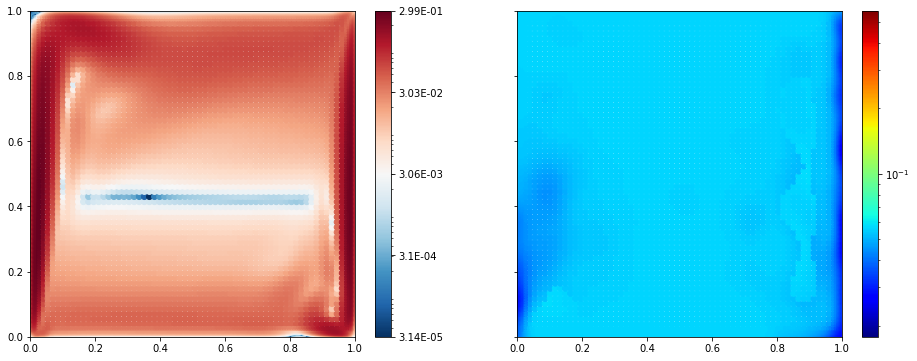

individual expert usage: ['8.31E-02', '1.37E-02', '9.02E-01', '0E+00', '0E+00', '7.53E-04', '0E+00']
Iter 88 , expert mean  -8.26E-02 , noise level  1E+00 , lambda  2.13E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.46E-02', '3.1E-02', '9.05E-03', '6.03E-02', '6.45E-02', '4.38E-02', '5.43E-02']
Loss: 3.88E-05 = 1.48E-05 (objective) + 1.39E-06 (bandwidth penalty) + 1.27E-05 (load penalty) + 9.9E-06 (non-sparseness penalty)
current validation RMSE:  0.004128963439470592
current learning rate:  2E-02


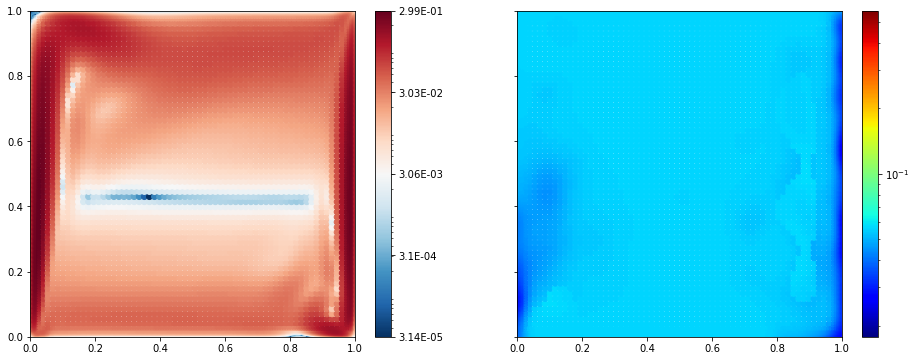

individual expert usage: ['8.21E-02', '1.21E-02', '9.05E-01', '0E+00', '0E+00', '7.98E-04', '0E+00']
Iter 92 , expert mean  -8.35E-02 , noise level  1E+00 , lambda  2.13E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.39E-02', '3.01E-02', '8.43E-03', '6.03E-02', '6.45E-02', '4.36E-02', '5.44E-02']
Loss: 3.46E-05 = 1.2E-05 (objective) + 1.39E-06 (bandwidth penalty) + 1.28E-05 (load penalty) + 8.33E-06 (non-sparseness penalty)
current validation RMSE:  0.004114259888015275
current learning rate:  2E-02


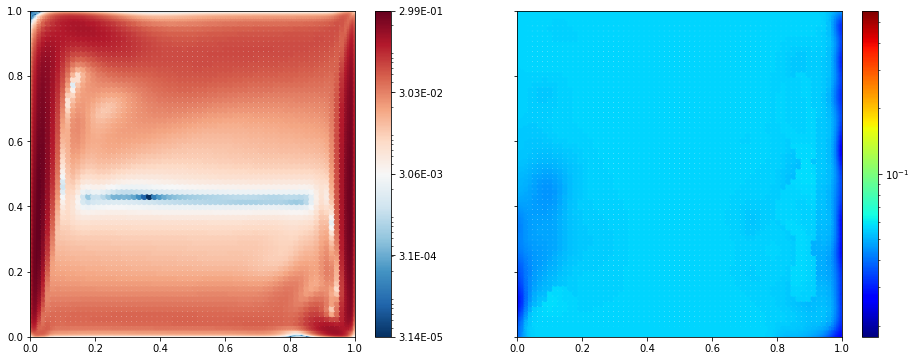

individual expert usage: ['8.07E-02', '1.06E-02', '9.08E-01', '0E+00', '0E+00', '8.09E-04', '0E+00']
Iter 96 , expert mean  -8.37E-02 , noise level  1E+00 , lambda  2.12E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.32E-02', '2.94E-02', '7.87E-03', '6.03E-02', '6.45E-02', '4.36E-02', '5.48E-02']
Loss: 3.51E-05 = 1.38E-05 (objective) + 1.38E-06 (bandwidth penalty) + 1.21E-05 (load penalty) + 7.8E-06 (non-sparseness penalty)
current validation RMSE:  0.004097692478407898
current learning rate:  2E-02


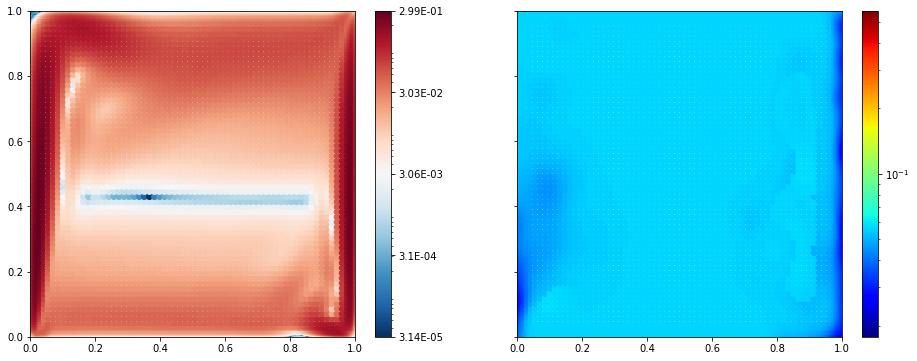

individual expert usage: ['8.08E-02', '9.67E-03', '9.09E-01', '0E+00', '0E+00', '8.49E-04', '7.83E-07']
Iter 100 , expert mean  -8.42E-02 , noise level  1E+00 , lambda  2.12E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.25E-02', '2.87E-02', '7.39E-03', '6.03E-02', '6.45E-02', '4.43E-02', '5.54E-02']
Loss: 3.82E-05 = 1.69E-05 (objective) + 1.4E-06 (bandwidth penalty) + 1.18E-05 (load penalty) + 8.09E-06 (non-sparseness penalty)
current validation RMSE:  0.0039133655136113915
current learning rate:  2E-02


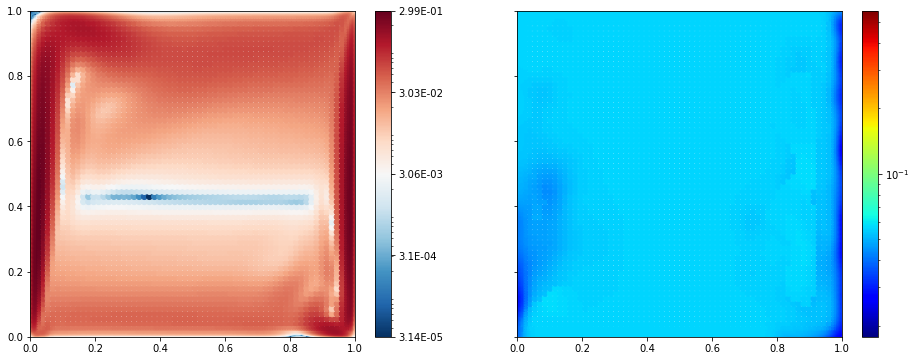

individual expert usage: ['8.17E-02', '8.59E-03', '9.09E-01', '0E+00', '0E+00', '9.96E-04', '6.04E-05']
Iter 104 , expert mean  -8.57E-02 , noise level  1E+00 , lambda  2.11E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.2E-02', '2.84E-02', '6.94E-03', '6.03E-02', '6.45E-02', '4.49E-02', '5.51E-02']
Loss: 3.09E-05 = 1.27E-05 (objective) + 1.39E-06 (bandwidth penalty) + 1.11E-05 (load penalty) + 5.7E-06 (non-sparseness penalty)
current validation RMSE:  0.003969051374846928
current learning rate:  2E-02


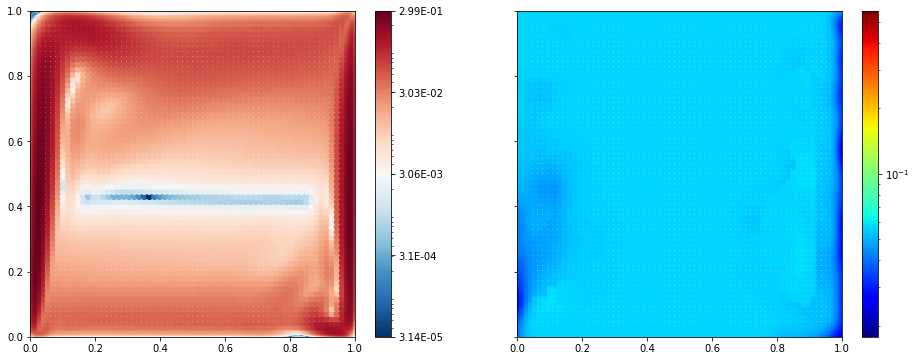

individual expert usage: ['8.01E-02', '7.37E-03', '9.11E-01', '0E+00', '0E+00', '1.43E-03', '6.66E-05']
Iter 108 , expert mean  -8.43E-02 , noise level  1E+00 , lambda  2.1E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.15E-02', '2.81E-02', '6.58E-03', '6.03E-02', '6.45E-02', '4.56E-02', '5.52E-02']
Loss: 3.58E-05 = 1.75E-05 (objective) + 1.4E-06 (bandwidth penalty) + 1.04E-05 (load penalty) + 6.54E-06 (non-sparseness penalty)
current validation RMSE:  0.003960352939777155
current learning rate:  1E-02


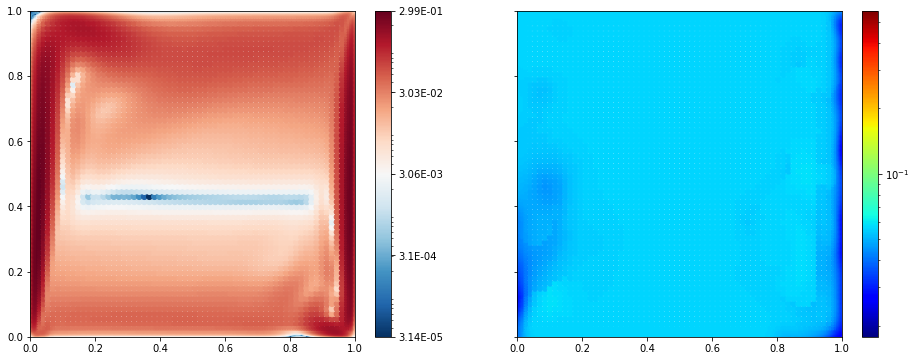

individual expert usage: ['7.96E-02', '6.14E-03', '9.12E-01', '0E+00', '0E+00', '2.01E-03', '5.74E-05']
Iter 112 , expert mean  -8.6E-02 , noise level  1E+00 , lambda  2.11E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.12E-02', '2.78E-02', '6.42E-03', '6.03E-02', '6.45E-02', '4.55E-02', '5.52E-02']
Loss: 2.68E-05 = 9.54E-06 (objective) + 1.39E-06 (bandwidth penalty) + 9.75E-06 (load penalty) + 6.15E-06 (non-sparseness penalty)
current validation RMSE:  0.0032680631237728404
current learning rate:  1E-02


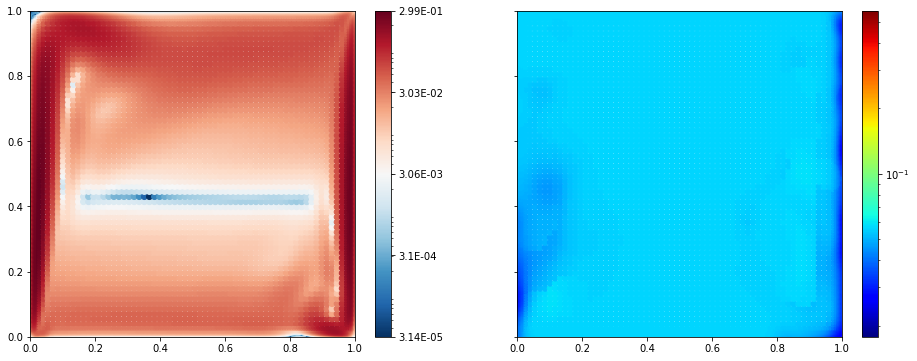

individual expert usage: ['7.94E-02', '5.52E-03', '9.13E-01', '0E+00', '0E+00', '2.36E-03', '5.53E-05']
Iter 116 , expert mean  -8.57E-02 , noise level  1E+00 , lambda  2.12E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.1E-02', '2.75E-02', '6.29E-03', '6.03E-02', '6.45E-02', '4.51E-02', '5.52E-02']
Loss: 2.4E-05 = 8.69E-06 (objective) + 1.39E-06 (bandwidth penalty) + 9.38E-06 (load penalty) + 4.58E-06 (non-sparseness penalty)
current validation RMSE:  0.003188311393746943
current learning rate:  5E-03


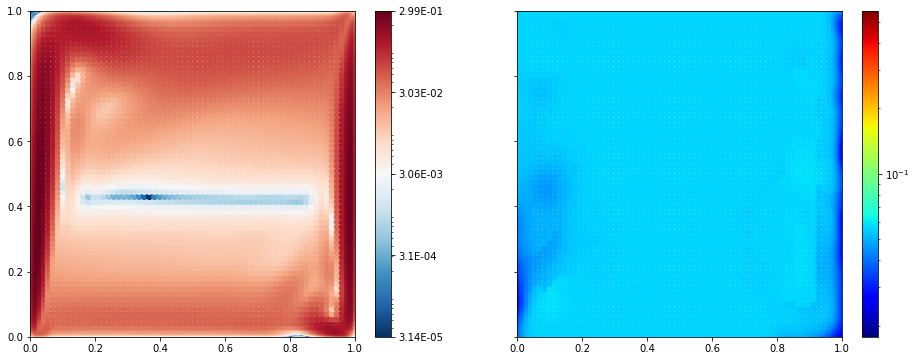

individual expert usage: ['7.9E-02', '4.88E-03', '9.13E-01', '0E+00', '0E+00', '2.72E-03', '5.34E-05']
Iter 120 , expert mean  -8.61E-02 , noise level  1E+00 , lambda  2.13E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.09E-02', '2.73E-02', '6.21E-03', '6.03E-02', '6.45E-02', '4.46E-02', '5.52E-02']
Loss: 2.21E-05 = 6.25E-06 (objective) + 1.37E-06 (bandwidth penalty) + 9.79E-06 (load penalty) + 4.69E-06 (non-sparseness penalty)
current validation RMSE:  0.003088582949524146
current learning rate:  5E-03


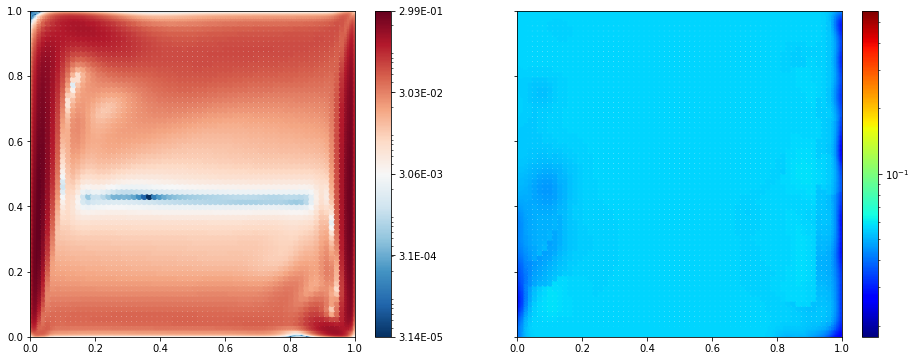

individual expert usage: ['7.87E-02', '4.53E-03', '9.14E-01', '0E+00', '0E+00', '2.94E-03', '5.23E-05']
Iter 124 , expert mean  -8.69E-02 , noise level  1E+00 , lambda  2.14E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.08E-02', '2.7E-02', '6.13E-03', '6.03E-02', '6.45E-02', '4.4E-02', '5.52E-02']
Loss: 2.35E-05 = 7.7E-06 (objective) + 1.39E-06 (bandwidth penalty) + 9.47E-06 (load penalty) + 4.98E-06 (non-sparseness penalty)
current validation RMSE:  0.0030540213391677387
current learning rate:  5E-03


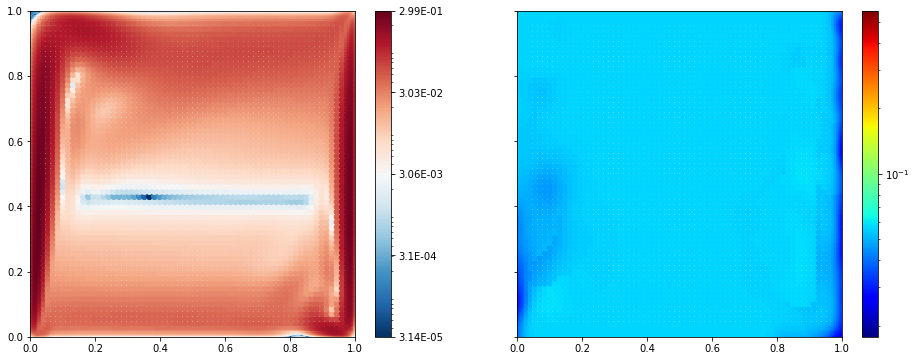

individual expert usage: ['7.83E-02', '4.31E-03', '9.14E-01', '0E+00', '0E+00', '2.99E-03', '5.31E-05']
Iter 128 , expert mean  -8.74E-02 , noise level  1E+00 , lambda  2.15E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.07E-02', '2.67E-02', '6.05E-03', '6.03E-02', '6.45E-02', '4.33E-02', '5.51E-02']
Loss: 2.33E-05 = 7.96E-06 (objective) + 1.38E-06 (bandwidth penalty) + 9.34E-06 (load penalty) + 4.6E-06 (non-sparseness penalty)
current validation RMSE:  0.0030980249263042846
current learning rate:  5E-03


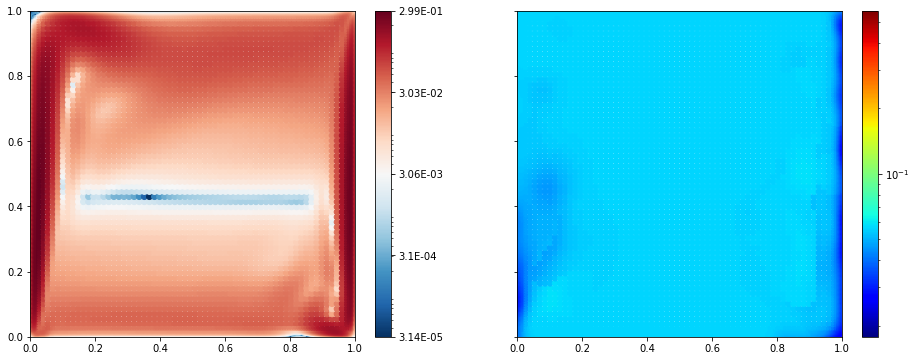

individual expert usage: ['7.81E-02', '4.15E-03', '9.15E-01', '0E+00', '0E+00', '3.01E-03', '5.35E-05']
Iter 132 , expert mean  -8.74E-02 , noise level  1E+00 , lambda  2.16E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.05E-02', '2.65E-02', '5.97E-03', '6.03E-02', '6.45E-02', '4.25E-02', '5.51E-02']
Loss: 2.31E-05 = 7.77E-06 (objective) + 1.38E-06 (bandwidth penalty) + 9.31E-06 (load penalty) + 4.67E-06 (non-sparseness penalty)
current validation RMSE:  0.0030500570046915
current learning rate:  2.5E-03


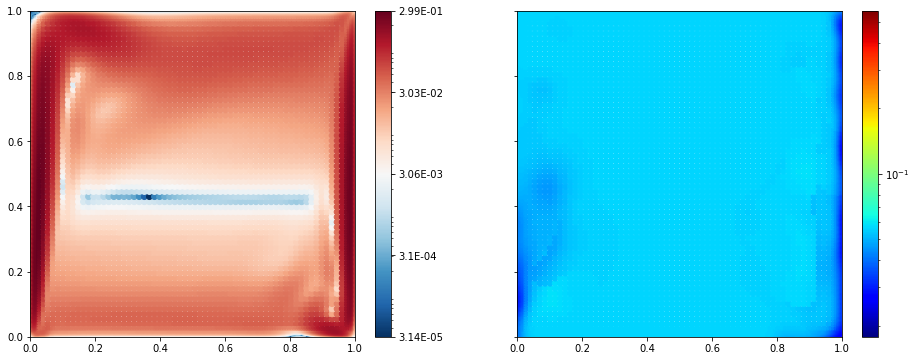

individual expert usage: ['7.75E-02', '3.97E-03', '9.15E-01', '0E+00', '0E+00', '3.03E-03', '5.29E-05']


KeyboardInterrupt: 

In [7]:
nnPars['smallBandwidthPenalty'] = 1e-6
nnPars['unequalTrainingLoadPenalty'] = 1e-5
nnPars['nonSparsenessPenalty'] = 1e-3

saberAL = saberActiveLearner(nnPars, inputSpaceBounds, None, testDensity, None, refTrainSize, (xPlot if useXRef else None), Q = Q, homoscedastic = homoscedastic, randPInit = None, pInit = testDensity, xVal = validationX, yVal = validationY)
# set up current training distribution
#saberAL.updateTrainingDistribution()

#saberAL.growTrainingData(batchSize)
saberAL.X = currentX
saberAL.y = currentY

# set up a dictionary for later reconstruction of local properties from intermediate iterations
densityInformation = {}
densityInformation['globalNoiseLevel'] = saberAL.globalNoiseLevel
densityInformation['vRef'] = None
densityInformation['sigmaRef'] = None
densityInformation['complexityRef'] = None
if saberAL.xRef is None:
    densityInformation['trainingDensityRef'] = None
else:
    # before appending density information, the newest pNext is the actual training density at this point; after appending, pNext describes the next density
    densityInformation['trainingDensityRef'] = pCurrentPlot
densityInformation['trainSize'] = len(saberAL.X)
densityInformation['proposalDensityNormalization'] = 1.
densityInformation['proposalDensityRef'] = None
densityInformation['densityWeight'] = None
saberAL.densitiesInformation.append(densityInformation)

#saberAL.updateTrainImportanceWeights()
saberAL.importanceWeights = testDensityTrain/pCurrentTrain
saberAL.importanceWeights *= len(saberAL.X)/np.sum(saberAL.importanceWeights)

######## estimate locally optimal bandwidths and new proposal density on reference data ####
saberAL.trainSABERModel(printMethod = printMethodSABER, initialExperts = initialExperts)

saberAL.SABERmodel.eval()
saberAL.updateLocalProperties(updateNoise = True, updateBandwidths = True)
# measure performance
with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    testPred, = saberAL.SABERmodel(torch.from_numpy(xTest).float(), predictionsOnly = True, labelsOnly = False)
testPred = testPred.numpy()
testRMSE = np.mean((testPred - fTest)**2)**0.5
testMaxAE = np.max(np.abs(testPred - fTest))
print('test rmse', testRMSE, 'maxAE', testMaxAE)

In [ ]:
nnPars['smallBandwidthPenalty'] = 1e-6
nnPars['unequalTrainingLoadPenalty'] = 1e-5
nnPars['nonSparsenessPenalty'] = 1e-3
nnPars['initialExpertLambda'] = 1e-2

Iter 128 , expert mean  -1.13E-01 , noise level  1E+00 , lambda  4.09E-02  , gate sigma  6E-02 , lambda  1E-01  noisy gating  ['1.44E-02', '5.65E-02', '1.07E-02', '7.44E-02', '7.68E-02', '4.84E-02', '4.54E-02', '3.87E-02', '1.18E-02']
Loss: 3.5E-05 = 6.46E-06 (objective) + 7.67E-07 (bandwidth penalty) + 1.7E-05 (load penalty) + 1.08E-05 (non-sparseness penalty)
current validation RMSE:  0.0026628333936956124

In [ ]:
# specify hyperparameters
######### TODO reasonable value for Q (e.g. Q = Inf)? #####################
Q = 1
homoscedastic = True
useXRef = True
refTrainSize = 7*1024
validationSize = len(xPlot) - refTrainSize
testSize = len(xPlot) - refTrainSize - validationSize

##### SABER hyperparameters ################
# learning rate ############################
nnPars = {}
nnPars['lrPre'] = 1e-1
nnPars['lr'] = 2e-2
nnPars['lrGate'] = 2e-3

nnPars['min_lr'] = 1e-4
nnPars['lrFactorGPRhyperparameters'] = 5e-1
nnPars['lrFactorInducingPointDist'] = 1.
nnPars['lrFactorInducingPoints'] = 0. # I have no good experience with adapting inducing point positions at all

# training parameters
nnPars['loss'] = 'mse' #'mll'
nnPars['weightDecay'] = 0.
nnPars['validationFrequency'] = 4
nnPars['baseBatchSize'] = int(2**8)
nnPars['EPOCH'] = 1000
nnPars['pretrainExpertEpochs'] = int(2**4)
if nnPars['loss'] == 'mll':
    nnPars['smallBandwidthPenalty'] = 1e-2
    nnPars['unequalTrainingLoadPenalty'] = 1e-2
    nnPars['nonSparsenessPenalty'] = 1e1
if nnPars['loss'] == 'mse':
    nnPars['smallBandwidthPenalty'] = 1e-6
    nnPars['unequalTrainingLoadPenalty'] = 1e-5
    nnPars['nonSparsenessPenalty'] = 1e-3
    
nnPars['unequalExpertLambdaPenalty'] = 0.
nnPars['unequalExpertMeanPenalty'] = 0.
nnPars['unequalExpertNoisePenalty'] = 0.

# parameters adaption as training size grows
nnPars['pretrainExpertEpochsScalingExponent'] = -1.
nnPars['validationFrequencyScalingExponent'] = -0.5
nnPars['expertLambdaScalingExponent'] = -0.5
nnPars['expertBandwidthScalingExponent'] = -0.
nnPars['batchSizeScalingExponent'] = 0.
nnPars['expertInducingPointScalingExponent'] = 0.
nnPars['gateInducingPointScalingExponent'] = 0.

# inducing point initialization strategy
nnPars['inducingPointInitialization'] = 'SVGD' # 'SVGD', 'Random', 'KMeans'
# SVGD related parameters
nnPars['svgdSigma'] = 1e-2
nnPars['svgdIters'] = 200
nnPars['svgdInitStepSize'] = 1e-2
nnPars['svgdFinalStepSize'] = 1e-4
nnPars['svgdRepulsionPropToDensity'] = True
nnPars['svgdVersion'] = 'v2'

nnPars['KMeansInit'] = 'k-means++' # 'random', 'k-means++'
nnPars['KMeansMaxIter'] = 300
nnPars['KMeansDistributional'] = True

# expert hyperparameters ####################
nnPars['fixedExpertLambda'] = False
nnPars['initialExpertLambda'] = 1e-2
nnPars['initExpertNoiseLevel'] = 1e0
nnPars['fixedExpertSigma'] = True
nnPars['fixedSharedExpertSigma'] = True
nnPars['expertBandwidths'] = 10**np.linspace(-12/8,-4/8,9)
nnPars['numExpertInducingPoints'] = 1024
nnPars['fixedExpertInducingPoints'] = True

# gate hyperparameters ######################
nnPars['gateOutputType'] = 'independent' #'independent', 'dependent'
nnPars['gateSigma'] = 6e-2
nnPars['gateLambda'] = 1e-1
nnPars['fixedGateSigma'] = True
nnPars['fixedGateLambda'] = True
nnPars['numGateInducingPoints'] = 256
nnPars['fixedGateInducingPoints'] = True

# MOE hyperparameters
nnPars['shareExpertMeanFromValiationIteration'] = 0 # 0, 10, np.Inf, whether we share the mean from the beginning, after some iteration or never; while the latter ones are more flexible, the first option is most stable
nnPars['shareExpertLambdaFromValiationIteration'] = 0 # 0, 10, np.Inf, whether we share the lambda from the beginning, after some iteration or never; while the latter ones are more flexible, the first option is most stable
nnPars['shareExpertNoiseFromValiationIteration'] = 0 # like above; however I am confident about using 0 here
nnPars['expertHardSparsity'] = 3 # the final maximal number of experts the gate chooses; note that for 1 expert we loose continuity of the regressor
nnPars['expertSoftSparsity'] = 2
nnPars['sparsifySoftAfterValiationIterations'] = 2
nnPars['initSoftSparsificationAfterValiationIterations'] = 5
nnPars['sparsifyHardAfterValiationIterations'] = 2
nnPars['initHardSparsificationAfterValiationIterations'] = 10
nnPars['noisy_gating'] = True
nnPars['noisy_gating_b'] = True
nnPars['noisy_gating_w'] = False
nnPars['gate_noise_stdDev'] = 1e-1
nnPars['inducingCovarType'] = 'scalar' # 'scalar', 'diag' or 'full'

# I have tuned the params for 512 inducing points. Thus we need to adapt sigma, if we change this number
nnPars['svgdSigma'] *= (nnPars['numExpertInducingPoints']/512)**(-1/inputDim)
        
ipInitString = '_ipInit' + nnPars['inducingPointInitialization']
if nnPars['inducingPointInitialization'] == 'SVGD':
    ipInitString += myScientificFormat(nnPars['svgdSigma'])
if nnPars['inducingPointInitialization'] == 'KMeans':
    if nnPars['KMeansInit'] == 'k-means++':
        ipInitString += 'Plus'
    if not nnPars['independentGateInducingPoints']:
        ipInitString += '_coupled'
        
expertString = '_expert'
# the expert IP description
expertString += '_IP'+str(nnPars['numExpertInducingPoints']) + ('_scaling'+myScientificFormat(nnPars['expertInducingPointScalingExponent']) if nnPars['expertInducingPointScalingExponent'] > 0 else '') + ('' if nnPars['fixedExpertInducingPoints'] else '_adaptive')
    
expertString += '_lambdaInit' + myScientificFormat(nnPars['initialExpertLambda']) + ('_individual' if nnPars['shareExpertLambdaFromValiationIteration'] == np.Inf else '')

expertString += '_sigRange' + myScientificFormat(nnPars['expertBandwidths'][0]) + 'to' + myScientificFormat(nnPars['expertBandwidths'][-1]) + '_' + str(len(nnPars['expertBandwidths'])) + ('_scaling' + myScientificFormat(-nnPars['expertBandwidthScalingExponent']) if nnPars['expertBandwidthScalingExponent'] < 0 else '') + ('' if nnPars['fixedSharedExpertSigma'] else '_tunable')

gateString = '_gate'
gateString += '_IP'+str(nnPars['numGateInducingPoints']) + ('' if nnPars['fixedGateInducingPoints'] else '_adaptive')
gateString += '_lambda' + myScientificFormat(nnPars['gateLambda'])
gateString += '_sigma' + myScientificFormat(nnPars['gateSigma'])
    
learningParametersString = '_eLR' + myScientificFormat(nnPars['lr']) + '_gLR' + myScientificFormat(nnPars['lrGate']) + '_batch' + str(nnPars['baseBatchSize']) + ('_scaling' + myScientificFormat(nnPars['batchSizeScalingExponent']) if nnPars['batchSizeScalingExponent'] > 0 else '') + '_gNoise' + myScientificFormat(nnPars['gate_noise_stdDev'])

penaltyString = '_pen'
penaltyString += '_load' + myScientificFormat(nnPars['unequalTrainingLoadPenalty'])
penaltyString += '_sig' + myScientificFormat(nnPars['smallBandwidthPenalty'])
penaltyString += '_sparse' + myScientificFormat(nnPars['nonSparsenessPenalty']) + '_' + str(nnPars['expertHardSparsity']) + '_' + str(nnPars['expertSoftSparsity'])
    
filename = dataName + '_SABER_'+str(Q) + expertString + gateString + ipInitString + learningParametersString + penaltyString

resultFile = os.path.join(saveDir, filename + '.tar')
resSABERopt_SABER = initResultListSABER(repetitions, 1, resultFile)

def printMethodSABER(saberAL, saberModel):
    fig, axes = plt.subplots(1, 2, sharex = True,sharey=True)
    fig.set_figheight(6)
    fig.set_figwidth(16)
    plt0 = axes[0].scatter(xPlot[:,0], xPlot[:,1], c=yPlot.flat, norm=colors.LogNorm(vmin=min(yPlot), vmax=max(yPlot)), s=4/densityPlot, cmap="RdBu_r")
    ticks = np.logspace(np.log10(min(yPlot)), np.log10(max(yPlot)), 5)
    cbar0 = plt.colorbar(plt0,ax=axes[0], ticks=ticks.ravel())
    null = cbar0.ax.set_yticklabels([myScientificFormat(a) for a in ticks.flat])
    
    saberModel.eval()
    with torch.no_grad():
        prediction, expert_output_distributions, gateValues, inxes, sigmaPlot = saberModel(torch.from_numpy(xPlot).float(), returnSigmaPredictions = True, combine = False)
    
    z1_plot = axes[1].scatter(xPlot[:,0], xPlot[:,1], c=sigmaPlot, s=4/densityPlot, cmap="jet", norm=colors.LogNorm(vmin=saberModel.expertBandwidths.numpy().min(), vmax=saberModel.expertBandwidths.numpy().max())) #norm=colors.LogNorm(vmin=min(sigmaPlot), vmax=max(sigmaPlot)))
    plt.colorbar(z1_plot,ax=axes[1])
    
    if np.ndim(axes) == 0:
        axes.set_xlim((0,1))
        axes.set_ylim((0,1))
    elif np.ndim(axes) == 1:
        for bb in axes:
            bb.set_xlim((0,1))
            bb.set_ylim((0,1))
    else:
        for aa in axes:
            for bb in aa:
                bb.set_xlim((0,1))
                bb.set_ylim((0,1))
    plt.draw()
    plt.pause(2)
    plt.close(fig)
    
    expertUsage = [vals.sum().item()/len(xPlot) for vals in gateValues]
    print('individual expert usage:', [myScientificFormat(u,2) for u in expertUsage])
    
    saberModel.train()

testDensityPlot = densityPlot
pCurrentPlot = densityPlot
newIterWasCalculated = False
for rep in range(repetitions):
    ####### set up global stuff for this repetition here (like validation and test data) ######
    seed = 2*rep
    np.random.seed(seed)
    torch.manual_seed(seed+1)
    
    # separate a validation set from training set
    randInx = np.random.permutation(len(xPlot))
    valInx = randInx[:validationSize]
    testInx = randInx[validationSize:(validationSize+testSize)]
    trainInx = randInx[(validationSize+testSize):]
    validationX = xPlot[valInx]
    validationY = yPlot[valInx]
    if len(testInx) > 0:
        xTest = xPlot[testInx]
        fTest = yPlot[testInx]
    else:
        xTest = validationX
        fTest = validationY
        
    currentX = xPlot[trainInx]
    currentY = yPlot[trainInx]
    pCurrentTrain = pCurrentPlot[trainInx]
    testDensityTrain = testDensityPlot[trainInx]
    n = len(currentX)
        
    trainImportanceWeights = testDensityTrain/pCurrentTrain
    trainImportanceWeights *= n/np.sum(trainImportanceWeights)
    
    # set up the learner
    saberAL = saberActiveLearner(nnPars, inputSpaceBounds, None, testDensity, None, refTrainSize, (xPlot if useXRef else None), Q = Q, homoscedastic = homoscedastic, randPInit = None, pInit = testDensity, xVal = validationX, yVal = validationY)
    if rep < len(resSABERopt_SABER['allXs']):
        continue
    newIterWasCalculated = True
    # set up current training distribution
    #saberAL.updateTrainingDistribution()

    #saberAL.growTrainingData(batchSize)
    saberAL.X = currentX
    saberAL.y = currentY

    # set up a dictionary for later reconstruction of local properties from intermediate iterations
    densityInformation = {}
    densityInformation['globalNoiseLevel'] = saberAL.globalNoiseLevel
    densityInformation['vRef'] = None
    densityInformation['sigmaRef'] = None
    densityInformation['complexityRef'] = None
    if saberAL.xRef is None:
        densityInformation['trainingDensityRef'] = None
    else:
        # before appending density information, the newest pNext is the actual training density at this point; after appending, pNext describes the next density
        densityInformation['trainingDensityRef'] = pCurrentPlot
    densityInformation['trainSize'] = len(saberAL.X)
    densityInformation['proposalDensityNormalization'] = 1.
    densityInformation['proposalDensityRef'] = None
    densityInformation['densityWeight'] = None
    saberAL.densitiesInformation.append(densityInformation)

    #saberAL.updateTrainImportanceWeights()
    saberAL.importanceWeights = testDensityTrain/pCurrentTrain
    saberAL.importanceWeights *= len(saberAL.X)/np.sum(saberAL.importanceWeights)
    
    ######## estimate locally optimal bandwidths and new proposal density on reference data ####
    seed = 2*rep + 1
    np.random.seed(seed)
    torch.manual_seed(seed+1)
    saberAL.trainSABERModel(printMethod = printMethodSABER)
    
    ####### evalutation of local model #########################
    saberAL.SABERmodel.eval()
    saberAL.updateLocalProperties(updateNoise = True, updateBandwidths = True)
    # measure performance
    with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
        testPred, = saberAL.SABERmodel(torch.from_numpy(xTest).float(), predictionsOnly = True)
        
    testPred = testPred.numpy()
    testRMSE = np.mean((testPred - fTest)**2)**0.5
    testMaxAE = np.max(np.abs(testPred - fTest))

    resSABERopt_SABER['allSABERrmse'][rep] = testRMSE
    resSABERopt_SABER['allSABERmaxAE'][rep] = testMaxAE

    # show some statistics
    #clear_output()
    
    fig, axes = plt.subplots(2, 2, sharex = True,sharey=True)
    fig.set_figheight(12)
    fig.set_figwidth(15)
    plt0 = axes[0,0].scatter(xPlot[:,0], xPlot[:,1], c=yPlot.flat, norm=colors.LogNorm(vmin=min(yPlot), vmax=max(yPlot)), s=4/densityPlot, cmap="RdBu_r")
    ticks = np.logspace(np.log10(min(yPlot)), np.log10(max(yPlot)), 5)
    cbar0 = plt.colorbar(plt0,ax=axes[0,0], ticks=ticks.ravel())
    null = cbar0.ax.set_yticklabels([myScientificFormat(a) for a in ticks.flat])
    pTrainScaled = saberAL.densitiesInformation[0]['trainingDensityRef'] / saberAL.densitiesInformation[0]['trainingDensityRef'].min()
    z1_plot = axes[0,1].scatter(xPlot[:,0], xPlot[:,1], c=pTrainScaled, s=4/densityPlot, cmap="jet", norm=colors.LogNorm(vmin=min(pTrainScaled), vmax=max(pTrainScaled)))
    ticks = np.logspace(np.log10(1), np.log10(16), 3)
    cbar1 = plt.colorbar(z1_plot,ax=axes[0,1], ticks=ticks.ravel())
    null = cbar1.ax.set_yticklabels([myScientificFormat(a) for a in ticks])
    
    z2_plot = axes[1,0].scatter(xPlot[:,0], xPlot[:,1], c=saberAL.densitiesInformation[0]['sigmaRef'], s=4/densityPlot, cmap="jet", norm=colors.LogNorm(vmin=min(saberAL.densitiesInformation[0]['sigmaRef']), vmax=max(saberAL.densitiesInformation[0]['sigmaRef'])))
    plt.colorbar(z2_plot,ax=axes[1,0])
    
    pProposalScaled = saberAL.densitiesInformation[0]['proposalDensityRef'] / saberAL.densitiesInformation[0]['proposalDensityRef'].min()
    z3_plot = axes[1,1].scatter(xPlot[:,0], xPlot[:,1], c=pProposalScaled, s=4/densityPlot, cmap="jet", norm=colors.LogNorm(vmin=min(pProposalScaled), vmax=max(pProposalScaled)))
    ticks = np.logspace(np.log10(1), np.log10(16), 3)
    cbar3 = plt.colorbar(z3_plot,ax=axes[1,1], ticks=ticks.ravel())
    null = cbar3.ax.set_yticklabels([myScientificFormat(a) for a in ticks])
    
    if np.ndim(axes) == 0:
        axes.set_xlim((0,1))
        axes.set_ylim((0,1))
    elif np.ndim(axes) == 1:
        for bb in axes:
            bb.set_xlim((0,1))
            bb.set_ylim((0,1))
    else:
        for aa in axes:
            for bb in aa:
                bb.set_xlim((0,1))
                bb.set_ylim((0,1))
    plt.draw()
    plt.pause(2)
    plt.close(fig)

    print('median RMSE')
    print(np.nanmedian(resSABERopt_SABER['allSABERrmse'],0))
    print('median max AE')
    print(np.nanmedian(resSABERopt_SABER['allSABERmaxAE'],0))
    
    resSABERopt_SABER = updateResultListSABER(resSABERopt_SABER, rep, saberAL.X, saberAL.y, saberAL.densitiesInformation, saberAL.SABERmodelsStateDict, saberAL.likelihoods)

    saveALresultSABER(resultFile, resSABERopt_SABER)
    
if not newIterWasCalculated:
    clear_output()
    print('median RMSE')
    print(np.nanmedian(resSABERopt_SABER['allSABERrmse'],0))
    print('median max AE')
    print(np.nanmedian(resSABERopt_SABER['allSABERmaxAE'],0))

In [ ]:
from sklearn.neighbors import NearestNeighbors
numGridCells = 36
#
gridPoints = np.linspace(0.5/numGridCells,1-0.5/numGridCells,numGridCells)
xx,yy = np.meshgrid(gridPoints, gridPoints)
XGrid = np.column_stack((xx.flat,yy.flat))

# need an average proposal Density estimate on XGrid
optDensity = 0
for rep in range(len(resPOptNN_NN['allXs'])):
    nnAL = nnActiveLearner(Q, inputSpaceBounds, nnPars, homoscedastic, oneNNtoXRefPredictor, nbrsXPlot, boundaryStdDevs, xPlot, yPlot, testDensityPlot, xVal = None, yVal = None)
    if Q == np.Inf:
        nnAL.proposalDensityRef = resPOptNN_NN['allRefXDensities'][rep][0]
    else:
        nnAL.trainingDensityRef = densityPlot
        nnAL.modelNN = resPOptNN_NN['allNets'][rep][0]
        nnAL.updateLocalProperties()
    optDensity += nnAL.proposalDensityEstimate(XGrid)
optDensity /= len(resPOptNN_NN['allXs'])

optDensity /= min(optDensity)
shift = np.log(max(optDensity) / min(optDensity)) / np.log(4)
shift -= np.floor(shift)
shift /= 2
optDensity = optDensity / 4**shift
#optDensity /= min(optDensity)/0.75

ll = np.array([1, 4, 16, 64])
ee = euclidean_distances(np.log(optDensity.reshape(optDensity.size,1)),np.log(ll).reshape(ll.size,1))
meanLevels = ll[np.argmin(ee, 1)]
meanLevels = (np.log(meanLevels) / np.log(4)).astype(int)+1

gridPoints = np.linspace(0,1,numGridCells+1)
boxLength = gridPoints[1]-gridPoints[0]
allX = []
allCellLevels = []
for xBox in range(numGridCells):
    for yBox in range(numGridCells):
        cellLevel = meanLevels[numGridCells*yBox+xBox]
        subCells = 2**(cellLevel-1)
        cellDist = boxLength / subCells
        newX = np.zeros((subCells**2,2))
        for i in range(subCells):
            for j in range(subCells):
                newX[i+subCells*j, 0] = gridPoints[xBox]+cellDist*(i+0.5)
                newX[i+subCells*j, 1] = gridPoints[yBox]+cellDist*(j+0.5)
        allX.append(newX)
        newLevels = np.ones((subCells**2,1))*cellLevel
        allCellLevels.append(newLevels)
allX = np.row_stack(allX)
allCellLevels = np.row_stack(allCellLevels)
print(allX.shape)
print(heatDataset['X'].shape)

plt.clf()
fig, axes = plt.subplots(1, 2, sharex = True,sharey=True)
fig.set_figheight(6)
fig.set_figwidth(16)

z0_plot = axes[0].scatter(XGrid[:,0], XGrid[:,1], c=optDensity, norm=colors.LogNorm(vmin=min(optDensity), vmax=max(optDensity)), s=25, cmap="jet")
ticks = np.logspace(np.log10(min(optDensity)), np.log10(max(optDensity)), 5)
cbar0 = plt.colorbar(z0_plot,ax=axes[0], ticks=ticks)
null = cbar0.ax.set_yticklabels([myScientificFormat(a) for a in ticks])
axes[0].title.set_text('Optimal Density')

z1_plot = axes[1].scatter(allX[:,0], allX[:,1], c=allCellLevels.flat, s=1, cmap="jet")
cbar1 = plt.colorbar(z1_plot,ax=axes[1], ticks = [1,2,3,4])
cbar1.ax.set_title('Level')
axes[1].title.set_text('Adapted Grid')
#fig.savefig('thermalCavity_Ra1e7/thermalCavity_Ra1e7_adaptiveGridFromMean_3rdIter_'+str(numGridCells)+'bins.pdf', bbox_inches='tight')
#np.savetxt('thermalCavity_Ra1e7/thermalCavity_Ra1e7_adaptiveGridFromMean_3rdIter_'+str(numGridCells)+'bins.csv', meanLevels, delimiter=",")